# Table of Contents <a class="anchor" id="TOC"></a>

* [Imports / options / functions](#section1)
* [Reading the data](#section2)
* [Discovering variables](#section3)
* [Data Cleaning](#section4)
    * [Handling columns names](#section4.1)
    * [Looking for missing values](#section4.2)
    * [Looking for duplicates](#section4.3)
    * [Deleting useless rows](#section4.4)
    * [Deleting useless columns](#section4.5)
    * [Handling dtypes](#section4.6)
    * [Looking for outliers](#section4.7)
* [Save data](#section5)
* [First Modeling](#section6)
* [Feature Engineering](#section7)
* [Second Modeling](#section8)
* [Feature Selection](#section9)
 

# Imports / options / functions <a class="anchor" id="section1"></a>
* [Table of Contents](#TOC)

In [1]:
import os
import time
import gc
from tqdm import tqdm
import datetime
from dateutil import relativedelta
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import statistics
import scipy
import random
import math
import sklearn
import re

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Preprocess
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder 
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import RobustScaler

# Sampling
from imblearn.over_sampling import SMOTE 

# Viz
from sklearn.decomposition import PCA

# Modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Hyperparameters 
from skopt.space import Integer
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize
 
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Feature selection
from boruta import BorutaPy
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# Interpretation
import shap

In [2]:
#Functions for cleaning  

def getVarByTypes(dataframe,listTypes:list):
    listVariables=list(dataframe.select_dtypes(include=listTypes).columns)
    return listVariables

def resetIndex(dataframe): 
    dataframe.reset_index(drop=True, inplace=True)
    pass

def winsorize2(dataframe,variable,l=0.01):
    column=dataframe.loc[:,variable]
    mask=np.logical_not(np.ma.masked_invalid(column).mask).reshape(1,-1)[0]
    columnUnmasked=column.loc[mask]
    if len(columnUnmasked.value_counts())>3:
        variableWinsorized=winsorize(columnUnmasked,limits=[l,l])
        while len(np.unique(variableWinsorized))<3:
            l=l/2
            variableWinsorized = winsorize(columnUnmasked,limits=[l,l])
        dataframe.loc[mask,variable]=variableWinsorized
    else :
        #print("{} has too few values to be winsorized".format(variable))
        pass
    pass
 
def winsorizeAll(dataframe,idVar):
    resetIndex(dataframe)
    listVariables=getVarByTypes(dataframe,["int64",'float64'])
    listVariables=[var for var in listVariables if var not in idVar]
    for variable in listVariables:
        winsorize2(dataframe,variable)
    pass  

#Pipeline 

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    #the last transformer is ColumnTransformer's 'remainder'
    for transformer_in_columns in column_transformer.transformers_[:-1]:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names_out()
        # if no 'get_feature_names' function, use raw column name
        except AttributeError: 
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

def removeColinear(dataframe,numVar):
    corrs = dataframe.loc[:,numVar].corr()
    colinearIndexes=[]
    l=len(numVar)
    for i in range(l) :
        for j in range(i+1,l) : 
            if corrs.iloc[i,j]>0.9:
                miss_i = dataframe.loc[:,numVar[i]].isna().sum()
                miss_j = dataframe.loc[:,numVar[j]].isna().sum()
                if miss_i > miss_j :
                    colinearIndexes.append(i)
                else : 
                    colinearIndexes.append(j)
    var=[numVar[i] for i in range(l) if i not in colinearIndexes]
    return var

def removeDependent(dataframe,catVar):    
    dependentIndexes=[]
    l=len(catVar)
    for i in range(l) :
        for j in range(i+1,l) :
            contingencyTable = pd.crosstab(dataframe[catVar[i]],dataframe[catVar[j]])
            if (contingencyTable>5).all().all():
                chi2, p, dof, exp = scipy.stats.chi2_contingency(contingencyTable)
                if p<0.01:
                    miss_i = dataframe.loc[:,catVar[i]].isna().sum()
                    miss_j = dataframe.loc[:,catVar[j]].isna().sum()
                    if miss_i > miss_j :
                        dependentIndexes.append(i)
                    else : 
                        dependentIndexes.append(j)
                    
    var=[catVar[i] for i in range(l) if i not in dependentIndexes]
    return var

categoricalTransformer = Pipeline (steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('encoder', OneHotEncoder(handle_unknown='ignore'))])

numericalTransformer = Pipeline (steps=[('imputer', SimpleImputer(strategy='median'))])


def preprocess(dataframe,aggregation=False,_id=np.nan):
    # add standardScaler
    
    # Removing variables with too much missing values
    l= len(dataframe)
    dataframe = dataframe.loc[:,(dataframe.isna().sum()/l<0.5).values]
    
    # Removing individual with too much missing values
    l= len(dataframe.columns)
    dataframe = dataframe.loc[(dataframe.isna().sum(axis=1)/l<0.3),:]
    
    boolVar =  getVarByTypes(dataframe,["bool"])
    
    for var in boolVar:
        dataframe.loc[:,var]=dataframe[var].astype("int64")
    
    originalVar = list(dataframe.columns)
    
    catVar = getVarByTypes(dataframe,["object"])
    intVar = getVarByTypes(dataframe,["int64","float64"])    
    idBool = ["SK_ID" in col for col in intVar]
    numVar=[var for (var, remove) in zip(intVar, idBool) if not remove]
    idVar=[var for var in intVar if var not in numVar]
    
    # Removing colinear variables
    numVar = removeColinear(dataframe,numVar)
    catVar = removeDependent(dataframe,catVar)
               
    preprocessor = ColumnTransformer(transformers=[('cat', categoricalTransformer, catVar),
                                                   ( 'num', numericalTransformer, numVar)],
                                    remainder='drop')
    
    # Replacing some infinity values
    dataframe = dataframe.replace([np.inf, -np.inf], np.nan)
    
    df = preprocessor.fit_transform(dataframe)
    dfId = dataframe.loc[:,idVar].reset_index(drop = True)
    newVar=get_column_names_from_ColumnTransformer(preprocessor)
    if isinstance(df, np.ndarray):
        df=pd.DataFrame(df,columns=newVar)
    else:
        df=pd.DataFrame(df.todense(),columns=newVar)
    df=pd.concat((df,dfId),axis=1)
    
    catVarEncoded = [c for c in newVar if c not in originalVar]
    
    winsorizeAll(df,idVar)

    if aggregation :
        agg={}
        for var in numVar:
            agg[var]=["min", 'max',"median","mean","sum"]
        for var in catVarEncoded:
            agg[var]=["count","sum","mean"]

        df=df.groupby(_id).agg(agg)
        df.columns = ['_'.join(col) for col in df.columns.values]
    else :
        pass  
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    print(np.any(np.isnan(df)))
    print(np.all(np.isfinite(df)))
    
    return (df)

# Functions for feature engineering 

def countItems (string):
    return string.count(",")+1

def timeDiffDays(data,end,start):
    if type(end)==str:
         r=relativedelta.relativedelta(data[end],data[start])
    else:
        r=relativedelta.relativedelta(end,data[start])
    return (r.years*365+r.months*30+r.days)

# Avoir les variable catégorielles en tête une par une pour optimiser les résultats

# Functions for encoding / scaling 

def binarizer(dataframe):
    binarizer=Binarizer()
    binarizer.fit(dataframe)
    return binarizer

def LEncoderFit(dataframe):
    enc= LabelEncoder()
    enc.fit(dataframe)
    return enc

def OHEncoderFit(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore",sparse=False)
    enc.fit(dataframe)
    return enc

def TEncoderFit(dataframe):
    #pas avant échantillonage
    #le mettre en avant pour montrer que j'ai bien compris data leakage
    enc = TargetEncoder()
    enc.fit(dataframe)
    return enc

def transform(dataframe,transformer):
    df=transformer.transform(dataframe)
    return df

def encoderInvTransform(array,encoder):
    res=encoder.inverse_transform(array)
    return res

def scalingFit(dataframe):
    scaler = StandardScaler()
    scaler.fit(dataframe)
    return scaler

# Functions for modeling

def splitData(X,y):
    XTrain, XTest, yTrain, yTest = train_test_split(X,y, test_size=0.2)
    return XTrain, XTest, yTrain, yTest

def modeling(classifier, X, y, featuresSelected:list= ["All"], overSampling = False):
    
    X_=X
    if featuresSelected[0] != "All":
        X_=X_.loc[:,featuresSelected]
    XTrain, XTest, yTrain, yTest=splitData(X_,y)
    if overSampling:
        oversampling = SMOTE()
        XTrain, yTrain = oversampling.fit_resample(XTrain, yTrain)
    scoring = {"auc": make_scorer(roc_auc_score), "accuracy": make_scorer(accuracy_score)}
    cv = cross_validate(classifier,XTrain, yTrain , cv=4,scoring = scoring)
    print(np.mean(cv["test_auc"]))
    print(np.mean(cv["test_accuracy"]))
    #classifier.fit(XTrain, yTrain)
    classifier.fit(XTrain, yTrain,early_stopping_rounds=1000,eval_metric='auc', eval_set=[(XTest, yTest)])
    yPred=classifier.predict(XTest)
    print("classification report : ", classification_report(yTest,yPred))

    return classifier

def LOOencoding(data,SEU:bool=1):
    if SEU:
        y=data["SiteEnergyUse(kBtu)"]
    else:
        y=data["TotalGHGEmissions"]
    X=data.drop(columns=["SiteEnergyUse(kBtu)","TotalGHGEmissions"])
    categoricalX=getVarByTypes(X,"object")
    XTrain, XTest, yTrain, yTest=splitData(X,y)
    encoder=LeaveOneOutEncoder(cols=categoricalX)
    encoder.fit(XTrain,yTrain)
    XTrainTransformed=encoder.transform(XTrain)
    XTestTransformed=encoder.transform(XTest)
    return XTrainTransformed, XTestTransformed, yTrain , yTest

def modelingLOO(regressor, data, energy:bool, SEU:bool=1, featuresSelected:list= ["All"]):
    data_=data.copy()
    if featuresSelected[0] != "All":
        data_=data_.loc[:,featuresSelected]
    if energy :
        data_["ENERGYSTARScore"]=data["ENERGYSTARScore"]
    XTrain, XTest, yTrain, yTest= LOOencoding(data,SEU)  
    cv = cross_validate(regressor,XTrain, yTrain , cv=3)
    print(np.mean(cv["test_score"]))
    regressor.fit(XTrain, yTrain)
    yPred=regressor.predict(XTest)
    print("explained variance : ", explained_variance_score(yTest,yPred))
    print("mean absolute error : ", mean_absolute_error(yTest,yPred))
    print("median absolute error : ", median_absolute_error(yTest,yPred))
    print("mean squarred error : ", mean_squared_error(yTest,yPred))
    print("choice - mean squared log error : ", mean_squared_log_error(yTest,yPred))
    return regressor

def gridSearchElasticNet(X, y):
    X=X.drop(columns="ENERGYSTARScore")
    parameters={"alpha" : [0.0001,0.00015],
                "l1_ratio":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                "fit_intercept": [True],
                "normalize": [True,False],
                "warm_start":[True],
                "selection" :["cyclic","random"],
                "max_iter":[5000]
               }
    # Creating the classifier object
    elasticnet = linear_model.ElasticNet()
    score = make_scorer(mean_squared_log_error)
    classifier = GridSearchCV(elasticnet, parameters, cv=4, scoring =score)
    # Performing training
    classifier.fit(X, y)
    print(classifier.best_params_)
    print(classifier.best_score_)
    return classifier

def gridSearchGradientBoosting(X, y):
    X=X.drop(columns="ENERGYSTARScore")
    parameters = {"n_estimators" : [200],
                  "max_depth":[5,6,7],
                  "min_samples_split": [2,3],
                  "min_samples_leaf": [1,2],
                  "ccp_alpha":[1e-3,1e-4,1e-5],
                  "warm_start":[True]}
    # Creating the classifier object
    gradientBoosting = GradientBoostingRegressor()
    score = make_scorer(mean_squared_log_error)
    classifier = GridSearchCV(gradientBoosting, parameters, cv=4, scoring =score)
    # Performing training
    classifier.fit(X, y)
    print(classifier.best_params_)
    print(classifier.best_score_)
    return classifier

def selectFeatures(model,X,y,energy:bool):
    if not energy : 
        X=X.drop(columns="ENERGYSTARScore")
    XCol=X.columns
    nbCol=len(XCol)
    step=round(nbCol/30)
    selector = RFECV(model, min_features_to_select=5, step=step, cv=2)
    selector.fit(X,y)
    relevantCol=XCol[selector.support_]
    while (set(XCol)!=set(relevantCol)):
        X=X.loc[:,relevantCol]
        XCol=X.columns
        nbCol=len(XCol)
        step=round(nbCol/30)
        selector = RFECV(model, min_features_to_select=5, step=step, cv=2)
        selector.fit(X,y)
        relevantCol=XCol[selector.support_]
    return relevantCol



# Montrer l'efficacité par rapport à l'utilisation de la RAM 
# Faire attention à ce que le typage ne soit pas cassé
# Typé à l'arrache - déroulement , typé optimalement - déroulement



In [3]:
# KDE 

def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [4]:
# Fonctions pour l'ACP

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(30,30))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:])-0.1, max(pcs[d1,:])+0.1, min(pcs[d2,:])-0.1, max(pcs[d2,:])+0.1


            lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
            ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='30', ha='left', va='bottom', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(15,15))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='10', ha='left',va='bottom') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Reading the data <a class="anchor" id="section2"></a>
* [Table of Contents](#TOC)

In [5]:
applicationTrain = pd.read_csv('data\\application_train.csv', sep=',',encoding="utf-8")

In [6]:
applicationTest = pd.read_csv('data\\application_test.csv', sep=',',encoding="utf-8")

In [7]:
bureau = pd.read_csv('data\\bureau.csv', sep=',',encoding="utf-8")

In [8]:
bureauBalance = pd.read_csv('data\\bureau_balance.csv', sep=',',encoding="utf-8")

In [9]:
posCashBalance = pd.read_csv('data\\POS_CASH_balance.csv', sep=',',encoding="utf-8")

In [10]:
creditCardBalance = pd.read_csv('data\\credit_card_balance.csv', sep=',',encoding="utf-8")

In [11]:
instalmentsPayments = pd.read_csv('data\\installments_payments.csv', sep=',',encoding="utf-8")

In [12]:
previousApplication = pd.read_csv('data\\previous_application.csv', sep=',',encoding="utf-8")

In [13]:
sampleSubmission = pd.read_csv('data\\sample_submission.csv', sep=',',encoding="utf-8")

In [14]:
columnsDescription = pd.read_csv('data\\HomeCredit_columns_description.csv', sep=',',encoding= 'unicode_escape')

## reducing the number of individuals

In [15]:
#n=len(applicationTrain)
#applicationTrain=applicationTrain.sample(round(n/2),random_state=0,axis=0)

#bureau=bureau.loc[bureau["SK_ID_CURR"].isin(applicationTrain["SK_ID_CURR"].values).values,:]

#bureauBalance=bureauBalance.loc[bureauBalance["SK_ID_BUREAU"].isin(bureau["SK_ID_BUREAU"].values).values,:]

#previousApplication=previousApplication.loc[previousApplication["SK_ID_CURR"].isin(applicationTrain["SK_ID_CURR"].values).values,:]

#creditCardBalance=creditCardBalance.loc[creditCardBalance["SK_ID_PREV"].isin(previousApplication["SK_ID_PREV"].values).values,:]

#instalmentsPayments=instalmentsPayments.loc[instalmentsPayments["SK_ID_PREV"].isin(previousApplication["SK_ID_PREV"].values).values,:]

#posCashBalance=posCashBalance.loc[posCashBalance["SK_ID_PREV"].isin(previousApplication["SK_ID_PREV"].values).values,:]

## Feature engineering

In [16]:
creditCardBalance['OVER_LIMIT'] = creditCardBalance['AMT_BALANCE'] > creditCardBalance['AMT_CREDIT_LIMIT_ACTUAL']
creditCardBalance['BALANCE_CLEARED'] = creditCardBalance['AMT_BALANCE'] == 0.0
creditCardBalance['LOW_PAYMENT'] = creditCardBalance['AMT_PAYMENT_CURRENT'] < creditCardBalance['AMT_INST_MIN_REGULARITY']
creditCardBalance['LATE'] = creditCardBalance['SK_DPD'] > 0.0

In [17]:
posCashBalance['LATE_PAYMENT'] = posCashBalance['SK_DPD'] > 0.0
posCashBalance['INSTALLMENTS_PAID'] = posCashBalance['CNT_INSTALMENT'] - posCashBalance['CNT_INSTALMENT_FUTURE']

In [18]:
instalmentsPayments['LATE'] = instalmentsPayments['DAYS_ENTRY_PAYMENT'] > instalmentsPayments['DAYS_INSTALMENT']
instalmentsPayments['LOW_PAYMENT'] = instalmentsPayments['AMT_PAYMENT'] < instalmentsPayments['AMT_INSTALMENT']

In [19]:
bureauBalance['PAST_DUE'] = bureauBalance['STATUS'].isin(['1', '2', '3', '4', '5'])
bureauBalance['ON_TIME'] = bureauBalance['STATUS'] == '0'

In [20]:
bureau['LOAN_RATE'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM']

In [21]:
applicationTrain['LOAN_RATE'] = applicationTrain['AMT_ANNUITY'] / applicationTrain['AMT_CREDIT'] 
applicationTrain['CREDIT_INCOME_RATIO'] = applicationTrain['AMT_CREDIT'] / applicationTrain['AMT_INCOME_TOTAL']
applicationTrain['EMPLOYED_BIRTH_RATIO'] = applicationTrain['DAYS_EMPLOYED'] / applicationTrain['DAYS_BIRTH']
applicationTrain['EXT_SOURCE_SUM'] = applicationTrain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis = 1)
applicationTrain['EXT_SOURCE_MEAN'] = applicationTrain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
applicationTrain['AMT_REQ_SUM'] = applicationTrain[[x for x in applicationTrain.columns if 'AMT_REQ_' in x]].sum(axis = 1)

# Cleaning (na, dupli) , featureEngineering (creation) for each dataframe, merging 

## description

In [22]:
columnsDescription[columnsDescription["Row"]=="SK_DPD"]

,Unnamed: 0,Table,Row,Description,Special
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
171,174,credit_card_balance.csv,SK_DPD,DPD (Days past due) during the month on the pr...,NaN


## POS CASH balance (preprocess, merging)

In [ ]:
l= len(posCashBalance)

In [ ]:

posCashBalance = posCashBalance.loc[:,(posCashBalance.isna().sum()/l<0.5).values]
posCashBalance
    


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,LATE_PAYMENT,INSTALLMENTS_PAID
0,1803195,182943,-31,48.0,45.0,Active,0,0,False,3.0
1,1715348,367990,-33,36.0,35.0,Active,0,0,False,1.0
2,1784872,397406,-32,12.0,9.0,Active,0,0,False,3.0
3,1903291,269225,-35,48.0,42.0,Active,0,0,False,6.0
4,2341044,334279,-35,36.0,35.0,Active,0,0,False,1.0
...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0,True,6.0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0,True,12.0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0,True,10.0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0,True,12.0


In [ ]:
# Removing individual with too much missing values
l= len(posCashBalance.columns)
posCashBalance = posCashBalance.loc[(posCashBalance.isna().sum(axis=1)/l<0.3),:]
posCashBalance


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,LATE_PAYMENT,INSTALLMENTS_PAID
0,1803195,182943,-31,48.0,45.0,Active,0,0,False,3.0
1,1715348,367990,-33,36.0,35.0,Active,0,0,False,1.0
2,1784872,397406,-32,12.0,9.0,Active,0,0,False,3.0
3,1903291,269225,-35,48.0,42.0,Active,0,0,False,6.0
4,2341044,334279,-35,36.0,35.0,Active,0,0,False,1.0
...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0,True,6.0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0,True,12.0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0,True,10.0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0,True,12.0


In [ ]:
boolVar =  getVarByTypes(posCashBalance,["bool"])
boolVar


['LATE_PAYMENT']

In [95]:
for var in boolVar:
    posCashBalance.loc[:,var]=posCashBalance[var].astype("int64")



NameError: name 'posCashBalance' is not defined

In [27]:
posCashBalance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,LATE_PAYMENT,INSTALLMENTS_PAID
0,1803195,182943,-31,48.0,45.0,Active,0,0,0,3.0
1,1715348,367990,-33,36.0,35.0,Active,0,0,0,1.0
2,1784872,397406,-32,12.0,9.0,Active,0,0,0,3.0
3,1903291,269225,-35,48.0,42.0,Active,0,0,0,6.0
4,2341044,334279,-35,36.0,35.0,Active,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0,1,6.0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0,1,12.0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0,1,10.0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0,1,12.0


In [26]:
originalVar = list(posCashBalance.columns)
originalVar


['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'NAME_CONTRACT_STATUS',
 'SK_DPD',
 'SK_DPD_DEF',
 'LATE_PAYMENT',
 'INSTALLMENTS_PAID']

In [28]:
catVar = getVarByTypes(posCashBalance,["object"])
intVar = getVarByTypes(posCashBalance,["int64","float64"])    
idBool = ["SK_ID" in col for col in intVar]
numVar=[var for (var, remove) in zip(intVar, idBool) if not remove]
idVar=[var for var in intVar if var not in numVar]



In [29]:
print(numVar)
print(catVar)
print(idVar)


['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF', 'LATE_PAYMENT', 'INSTALLMENTS_PAID']
['NAME_CONTRACT_STATUS']
['SK_ID_PREV', 'SK_ID_CURR']


In [30]:
# Removing colinear variables
numVar = removeColinear(posCashBalance,numVar)
catVar = removeDependent(posCashBalance,catVar)

print(numVar)
print(catVar)

['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF', 'LATE_PAYMENT', 'INSTALLMENTS_PAID']
['NAME_CONTRACT_STATUS']


In [31]:

preprocessor = ColumnTransformer(transformers=[('cat', categoricalTransformer, catVar),
                                                ( 'num', numericalTransformer, numVar)],
                                remainder='drop')



In [32]:
# Replacing some infinity values
posCashBalance = posCashBalance.replace([np.inf, -np.inf], np.nan)


In [33]:
df = preprocessor.fit_transform(posCashBalance)


In [36]:
print(np.any(np.isnan(df)))
print(np.all(np.isfinite(df)))
    

False
True


In [35]:
len(df)

9975384

In [84]:
df

array([[  1.,   0.,   0., ...,  45.,   0.,   0.],
       [  1.,   0.,   0., ...,  35.,   0.,   0.],
       [  1.,   0.,   0., ...,   9.,   0.,   0.],
       ...,
       [  1.,   0.,   0., ...,   0., 609.,   0.],
       [  1.,   0.,   0., ...,   0., 614.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [41]:
dfId = posCashBalance.loc[:,idVar].reset_index(drop = True)
dfId

,SK_ID_PREV,SK_ID_CURR
0,1803195,182943
1,1715348,367990
2,1784872,397406
3,1903291,269225
4,2341044,334279
...,...,...
9975379,2448283,226558
9975380,1717234,141565
9975381,1283126,315695
9975382,1082516,450255


In [38]:
newVar=get_column_names_from_ColumnTransformer(preprocessor)
newVar

['x0_Active',
 'x0_Amortized debt',
 'x0_Approved',
 'x0_Canceled',
 'x0_Completed',
 'x0_Demand',
 'x0_Returned to the store',
 'x0_Signed',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF',
 'LATE_PAYMENT',
 'INSTALLMENTS_PAID']

In [39]:
if isinstance(df, np.ndarray):
    df=pd.DataFrame(df,columns=newVar)
else:
    df=pd.DataFrame(df.todense(),columns=newVar)

df


,x0_Active,x0_Amortized debt,x0_Approved,x0_Canceled,x0_Completed,x0_Demand,x0_Returned to the store,x0_Signed,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,LATE_PAYMENT,INSTALLMENTS_PAID
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-31.0,48.0,45.0,0.0,0.0,0.0,3.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-33.0,36.0,35.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-32.0,12.0,9.0,0.0,0.0,0.0,3.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-35.0,48.0,42.0,0.0,0.0,0.0,6.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-35.0,36.0,35.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975379,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,6.0,0.0,843.0,0.0,1.0,6.0
9975380,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,12.0,0.0,602.0,0.0,1.0,12.0
9975381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-21.0,10.0,0.0,609.0,0.0,1.0,10.0
9975382,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-22.0,12.0,0.0,614.0,0.0,1.0,12.0


In [40]:
df=pd.concat((df,dfId),axis=1)

df

,x0_Active,x0_Amortized debt,x0_Approved,x0_Canceled,x0_Completed,x0_Demand,x0_Returned to the store,x0_Signed,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,LATE_PAYMENT,INSTALLMENTS_PAID,SK_ID_PREV,SK_ID_CURR
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-31.0,48.0,45.0,0.0,0.0,0.0,3.0,1803195.0,182943.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-33.0,36.0,35.0,0.0,0.0,0.0,1.0,1715348.0,367990.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-32.0,12.0,9.0,0.0,0.0,0.0,3.0,1784872.0,397406.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-35.0,48.0,42.0,0.0,0.0,0.0,6.0,1903291.0,269225.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-35.0,36.0,35.0,0.0,0.0,0.0,1.0,2341044.0,334279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2448283.0,226558.0
10001354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1717234.0,141565.0
10001355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1283126.0,315695.0
10001356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1082516.0,450255.0


In [87]:
print(np.any(np.isnan(df)))
print(np.all(np.isfinite(df)))

MemoryError: Unable to allocate 1.19 GiB for an array with shape (16, 10001358) and data type float64

In [ ]:
    
    catVarEncoded = [c for c in newVar if c not in originalVar]
    
    winsorizeAll(df,idVar)

    if aggregation :
        agg={}
        for var in numVar:
            agg[var]=["min", 'max',"median","mean","sum"]
        for var in catVarEncoded:
            agg[var]=["count","sum","mean"]

        df=df.groupby(_id).agg(agg)
        df.columns = ['_'.join(col) for col in df.columns.values]
    else :
        pass  
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    

In [29]:
posCashBalance[posCashBalance["SK_ID_PREV"]==1107421.0]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,LATE_PAYMENT,INSTALLMENTS_PAID
9976332,1107421,164804,-37,1.0,0.0,Completed,0,0,False,1.0


In [28]:
test[np.isnan(test["MONTHS_BALANCE_min"])]

,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_median,MONTHS_BALANCE_mean,MONTHS_BALANCE_sum,CNT_INSTALMENT_min,CNT_INSTALMENT_max,CNT_INSTALMENT_median,CNT_INSTALMENT_mean,CNT_INSTALMENT_sum,...,x0_Completed_mean,x0_Demand_count,x0_Demand_sum,x0_Demand_mean,x0_Returnedtothestore_count,x0_Returnedtothestore_sum,x0_Returnedtothestore_mean,x0_Signed_count,x0_Signed_sum,x0_Signed_mean
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
1107421.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1143401.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1177015.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1230655.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1468455.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1538954.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1550592.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1588842.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
1598330.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN


In [23]:
test = preprocess(posCashBalance,aggregation=True,_id="SK_ID_PREV")

True
False


In [23]:
previousApplication = pd.merge(previousApplication,preprocess(posCashBalance,aggregation=True,_id="SK_ID_PREV"), how = "left",left_on="SK_ID_PREV",right_on="SK_ID_PREV",suffixes=("_prev","_pos"))

False
True


In [24]:
# Free up memory by deleting old objects

gc.enable()
del posCashBalance
gc.collect()

44

## instalments payments (preprocess, merging)

In [25]:
previousApplication = pd.merge(previousApplication,preprocess(instalmentsPayments,aggregation=True,_id="SK_ID_PREV"), how = "left",left_on="SK_ID_PREV",right_on="SK_ID_PREV",suffixes=("_prev","_instal"))

False
True


In [26]:
gc.enable()
del instalmentsPayments
gc.collect()

20

## credit card balance (preprocess, merging)

In [27]:
previousApplication = pd.merge(previousApplication,preprocess(creditCardBalance,aggregation=True,_id="SK_ID_PREV"), how = "left",left_on="SK_ID_PREV",right_on="SK_ID_PREV",suffixes=("_prev","_cred"))

False
True


In [28]:
gc.enable()
del creditCardBalance
gc.collect()

44

## previous application (preprocess, merging)

In [29]:
previousAppCounts = previousApplication.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'previousAppCounts'})
applicationTrain = applicationTrain.merge(previousAppCounts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
applicationTrain['previousAppCounts'] = applicationTrain['previousAppCounts'].fillna(0)

In [30]:
applicationTrain = pd.merge(applicationTrain,preprocess(previousApplication,aggregation=True,_id="SK_ID_CURR"), how = "left",left_on="SK_ID_CURR",right_on="SK_ID_CURR",suffixes=("_curr","_prev"))

False
True


In [31]:
gc.enable()
del previousApplication
gc.collect()

20

## bureau balance (preprocess, merging)

In [32]:
bureau = pd.merge(bureau,preprocess(bureauBalance,aggregation=True,_id="SK_ID_BUREAU"), how = "left",left_on="SK_ID_BUREAU",right_on="SK_ID_BUREAU",suffixes=("_bur","_burbal"))

False
True


In [33]:
gc.enable()
del bureauBalance
gc.collect()

20

## bureau (preprocess, merging)

In [34]:
previousLoanCounts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previousLoanCounts'})
applicationTrain = applicationTrain.merge(previousLoanCounts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
applicationTrain['previousLoanCounts'] = applicationTrain['previousLoanCounts'].fillna(0)

In [35]:
applicationTrain = pd.merge(applicationTrain,preprocess(bureau,aggregation=True,_id="SK_ID_CURR"), how = "left",left_on="SK_ID_CURR",right_on="SK_ID_CURR",suffixes=("_curr","_bureau"))

False
True


In [36]:
gc.enable()
del bureau
gc.collect()

20

## application

In [37]:
applicationTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 734 entries, SK_ID_CURR to x2_Unknowntypeofloan_mean
dtypes: float64(677), int64(41), object(16)
memory usage: 1.7+ GB


In [38]:
applicationTrain=preprocess(applicationTrain)
applicationTrain_y=applicationTrain["TARGET"]
applicationTrain_X=applicationTrain.drop(columns=["TARGET"])

False
True


In [39]:
applicationTrain.to_csv('applicationTrain.csv')
applicationTrain_y.to_csv('applicationTrain_y.csv')
applicationTrain_X.to_csv('applicationTrain_X.csv')

# Checkpoint

In [237]:
applicationTrain=pd.read_csv('applicationTrain.csv', index_col = 0)
applicationTrain_y=pd.read_csv('applicationTrain_y.csv', index_col = 0 )
applicationTrain_X=pd.read_csv('applicationTrain_X.csv', index_col = 0)

In [238]:
applicationTrain.head()

,x0_Cashloans,x0_Revolvingloans,x1_F,x1_M,x1_XNA,x2_N,x2_Y,x3_Businessman,x3_Commercialassociate,x3_Maternityleave,...,x2_Microloan_sum,x2_Microloan_mean,x2_Mobileoperatorloan_sum,x2_Mortgage_sum,x2_Mortgage_mean,x2_Realestateloan_sum,x2_Realestateloan_mean,x2_Unknowntypeofloan_sum,x2_Unknowntypeofloan_mean,SK_ID_CURR
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100002
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100003
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100004
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100006
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100007


# Modeling

## baseline with random under sampling

In [40]:
n=len(applicationTrain[applicationTrain["TARGET"]==1])

In [41]:
dataBaseline=applicationTrain[applicationTrain["TARGET"]==0].sample(n,random_state=0,axis=0)

In [42]:
dataBaseline=dataBaseline.append(applicationTrain[applicationTrain["TARGET"]==1])

In [43]:
under_y=dataBaseline["TARGET"]

In [44]:
under_X=dataBaseline.drop(columns=["TARGET","SK_ID_CURR"])

In [45]:
modeling(LGBMClassifier(),under_X,under_y)

0.7021511819842892
0.7021511143207699


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	valid_0's auc: 0.7149	valid_0's binary_logloss: 0.678889
[2]	valid_0's auc: 0.721771	valid_0's binary_logloss: 0.666926
[3]	valid_0's auc: 0.726083	valid_0's binary_logloss: 0.657061
[4]	valid_0's auc: 0.727605	valid_0's binary_logloss: 0.648851
[5]	valid_0's auc: 0.728362	valid_0's binary_logloss: 0.642212
[6]	valid_0's auc: 0.730536	valid_0's binary_logloss: 0.636181
[7]	valid_0's auc: 0.731564	valid_0's binary_logloss: 0.631183
[8]	valid_0's auc: 0.73287	valid_0's binary_logloss: 0.626755
[9]	valid_0's auc: 0.733733	valid_0's binary_logloss: 0.623115
[10]	valid_0's auc: 0.734446	valid_0's binary_logloss: 0.620033
[11]	valid_0's auc: 0.735599	valid_0's binary_logloss: 0.617098
[12]	valid_0's auc: 0.737085	valid_0's binary_logloss: 0.614349
[13]	valid_0's auc: 0.738184	valid_0's binary_logloss: 0.611999
[14]	valid_0's auc: 0.739	valid_0's binary_logloss: 0.610148
[15]	valid_0's auc: 0.740133	valid_0's binary_logloss: 0.608243
[16]	valid_0's auc: 0.740765	valid_0's binary_logloss: 

LGBMClassifier()

In [46]:
# regression logistic 
# modeling(,under_X,under_y)

## feature selection

In [47]:
feat_selector = BorutaPy(LGBMClassifier(num_boost_round = 100), n_estimators='auto', verbose=2, random_state=1)

In [48]:
feat_selector.fit(under_X.values, under_y.values)

Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	456
Rejected: 	0


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	456
Rejected: 	0


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	456
Rejected: 	0


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	456
Rejected: 	0


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	456
Rejected: 	0


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	456
Rejected: 	0


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	456
Rejected: 	0


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	409


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	31
Rejected: 	409


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	10 / 100
Confirmed: 	16
Tentative: 	31
Rejected: 	409


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	11 / 100
Confirmed: 	16
Tentative: 	31
Rejected: 	409


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	12 / 100
Confirmed: 	18
Tentative: 	24
Rejected: 	414


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	13 / 100
Confirmed: 	18
Tentative: 	24
Rejected: 	414


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	14 / 100
Confirmed: 	18
Tentative: 	24
Rejected: 	414


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	15 / 100
Confirmed: 	18
Tentative: 	24
Rejected: 	414


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	16 / 100
Confirmed: 	21
Tentative: 	19
Rejected: 	416


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	17 / 100
Confirmed: 	21
Tentative: 	19
Rejected: 	416


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	18 / 100
Confirmed: 	21
Tentative: 	19
Rejected: 	416


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	19 / 100
Confirmed: 	23
Tentative: 	17
Rejected: 	416


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	20 / 100
Confirmed: 	23
Tentative: 	17
Rejected: 	416


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	21 / 100
Confirmed: 	23
Tentative: 	16
Rejected: 	417


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	22 / 100
Confirmed: 	24
Tentative: 	15
Rejected: 	417


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	23 / 100
Confirmed: 	24
Tentative: 	15
Rejected: 	417


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	24 / 100
Confirmed: 	24
Tentative: 	15
Rejected: 	417


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	25 / 100
Confirmed: 	24
Tentative: 	15
Rejected: 	417


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	26 / 100
Confirmed: 	25
Tentative: 	13
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	27 / 100
Confirmed: 	25
Tentative: 	13
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	28 / 100
Confirmed: 	25
Tentative: 	13
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	29 / 100
Confirmed: 	26
Tentative: 	12
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	30 / 100
Confirmed: 	26
Tentative: 	12
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	31 / 100
Confirmed: 	26
Tentative: 	12
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	32 / 100
Confirmed: 	31
Tentative: 	7
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	33 / 100
Confirmed: 	31
Tentative: 	7
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	34 / 100
Confirmed: 	32
Tentative: 	6
Rejected: 	418


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	35 / 100
Confirmed: 	32
Tentative: 	5
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	36 / 100
Confirmed: 	32
Tentative: 	5
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	37 / 100
Confirmed: 	32
Tentative: 	5
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	38 / 100
Confirmed: 	32
Tentative: 	5
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	39 / 100
Confirmed: 	32
Tentative: 	5
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	40 / 100
Confirmed: 	33
Tentative: 	4
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	41 / 100
Confirmed: 	33
Tentative: 	4
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	42 / 100
Confirmed: 	33
Tentative: 	4
Rejected: 	419


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	43 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	44 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	45 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	46 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	47 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	48 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	49 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	50 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	51 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	52 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	53 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	54 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	55 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	56 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	57 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	58 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	59 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	60 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	61 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	62 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	63 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	64 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	65 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	66 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	67 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	68 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	69 / 100
Confirmed: 	33
Tentative: 	3
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	70 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	71 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	72 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	73 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	74 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	75 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	76 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	77 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	78 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	79 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	80 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	81 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	82 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	83 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	84 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	85 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	86 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	87 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	88 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	89 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	90 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	91 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	92 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	93 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	94 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	95 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	96 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	97 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	98 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


Found `num_boost_round` in params. Will use it instead of argument


Iteration: 	99 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	34
Tentative: 	2
Rejected: 	420


BorutaPy(estimator=LGBMClassifier(n_estimators=-848, num_boost_round=100,
                                  random_state=RandomState(MT19937) at 0x235F4611158),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x235F4611158, verbose=2)

In [49]:
feat_selector.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False,  True, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [50]:
feature_ranks = list(zip(applicationTrain.columns, feat_selector.ranking_, feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: x0_Cashloans              Rank: 31,  Keep: False
Feature: x0_Revolvingloans         Rank: 314,  Keep: False
Feature: x1_F                      Rank: 1,  Keep: True
Feature: x1_M                      Rank: 314,  Keep: False
Feature: x1_XNA                    Rank: 314,  Keep: False
Feature: x2_N                      Rank: 3,  Keep: False
Feature: x2_Y                      Rank: 314,  Keep: False
Feature: x3_Commercialassociate    Rank: 164,  Keep: False
Feature: x3_Maternityleave         Rank: 314,  Keep: False
Feature: x3_Pensioner              Rank: 314,  Keep: False
Feature: x3_Stateservant           Rank: 28,  Keep: False
Feature: x3_Student                Rank: 314,  Keep: False
Feature: x3_Unemployed             Rank: 314,  Keep: False
Feature: x3_Working                Rank: 12,  Keep: False
Feature: TARGET                    Rank: 194,  Keep: False
Feature: CNT_CHILDREN              Rank: 13,  Keep: False
Feature: AMT_INCOME_TOTAL          Rank: 1,  Keep: True
Feature: 

In [51]:
under_Xfiltered = feat_selector.transform(under_X.values)

In [52]:
modeling(LGBMClassifier(),under_Xfiltered,under_y)

0.6969141773664724
0.6969136763677896
[1]	valid_0's auc: 0.723561	valid_0's binary_logloss: 0.678295
[2]	valid_0's auc: 0.72949	valid_0's binary_logloss: 0.66594
[3]	valid_0's auc: 0.732365	valid_0's binary_logloss: 0.655737
[4]	valid_0's auc: 0.734254	valid_0's binary_logloss: 0.647136
[5]	valid_0's auc: 0.735125	valid_0's binary_logloss: 0.640066
[6]	valid_0's auc: 0.735831	valid_0's binary_logloss: 0.63423
[7]	valid_0's auc: 0.737517	valid_0's binary_logloss: 0.628909
[8]	valid_0's auc: 0.738017	valid_0's binary_logloss: 0.624597
[9]	valid_0's auc: 0.73923	valid_0's binary_logloss: 0.620656
[10]	valid_0's auc: 0.740329	valid_0's binary_logloss: 0.617181
[11]	valid_0's auc: 0.741593	valid_0's binary_logloss: 0.614121
[12]	valid_0's auc: 0.741997	valid_0's binary_logloss: 0.61168
[13]	valid_0's auc: 0.743351	valid_0's binary_logloss: 0.609259
[14]	valid_0's auc: 0.744245	valid_0's binary_logloss: 0.607168
[15]	valid_0's auc: 0.744639	valid_0's binary_logloss: 0.605554
[16]	valid_0's a

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.



[17]	valid_0's auc: 0.746603	valid_0's binary_logloss: 0.602208
[18]	valid_0's auc: 0.74766	valid_0's binary_logloss: 0.600606
[19]	valid_0's auc: 0.748444	valid_0's binary_logloss: 0.599378
[20]	valid_0's auc: 0.749085	valid_0's binary_logloss: 0.598256
[21]	valid_0's auc: 0.749495	valid_0's binary_logloss: 0.597275
[22]	valid_0's auc: 0.750093	valid_0's binary_logloss: 0.596325
[23]	valid_0's auc: 0.750699	valid_0's binary_logloss: 0.59543
[24]	valid_0's auc: 0.751509	valid_0's binary_logloss: 0.594453
[25]	valid_0's auc: 0.752089	valid_0's binary_logloss: 0.593671
[26]	valid_0's auc: 0.752868	valid_0's binary_logloss: 0.59272
[27]	valid_0's auc: 0.75351	valid_0's binary_logloss: 0.591942
[28]	valid_0's auc: 0.754407	valid_0's binary_logloss: 0.591004
[29]	valid_0's auc: 0.755069	valid_0's binary_logloss: 0.590275
[30]	valid_0's auc: 0.7556	valid_0's binary_logloss: 0.589621
[31]	valid_0's auc: 0.756204	valid_0's binary_logloss: 0.58898
[32]	valid_0's auc: 0.756959	valid_0's binary_

LGBMClassifier()

## oversampling

In [53]:
applicationTrain_X=applicationTrain_X.drop(columns=["SK_ID_CURR"])

In [54]:
over_X=applicationTrain[applicationTrain_X.columns[feat_selector.support_]]

In [55]:
model = modeling(LGBMClassifier(),over_X,applicationTrain_y, overSampling = True)

0.9441119941664318
0.9441124232612372


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	valid_0's auc: 0.687124	valid_0's binary_logloss: 0.653768
[2]	valid_0's auc: 0.693458	valid_0's binary_logloss: 0.620796
[3]	valid_0's auc: 0.698175	valid_0's binary_logloss: 0.591833
[4]	valid_0's auc: 0.701533	valid_0's binary_logloss: 0.568502
[5]	valid_0's auc: 0.703271	valid_0's binary_logloss: 0.548776
[6]	valid_0's auc: 0.703828	valid_0's binary_logloss: 0.531023
[7]	valid_0's auc: 0.70188	valid_0's binary_logloss: 0.515096
[8]	valid_0's auc: 0.702393	valid_0's binary_logloss: 0.50195
[9]	valid_0's auc: 0.702018	valid_0's binary_logloss: 0.489006
[10]	valid_0's auc: 0.70079	valid_0's binary_logloss: 0.477801
[11]	valid_0's auc: 0.699162	valid_0's binary_logloss: 0.466937
[12]	valid_0's auc: 0.698671	valid_0's binary_logloss: 0.457801
[13]	valid_0's auc: 0.699058	valid_0's binary_logloss: 0.44382
[14]	valid_0's auc: 0.698911	valid_0's binary_logloss: 0.431654
[15]	valid_0's auc: 0.700034	valid_0's binary_logloss: 0.424571
[16]	valid_0's auc: 0.703345	valid_0's binary_logloss

In [56]:
# feature engineering par lot 
# validation petit à petit (avec boruta / RFECV par bloc)
# explicable à un client

In [57]:
# hyper paramétrage (hyperopt / optuna / bayesOpt)

In [58]:
# insérer la métrique métier qui pénalise les faux positifs (google?)

In [59]:
# auc metric
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(over_X)
expected_value = explainer.expected_value

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [70]:
len(shap_values[0][0])

34

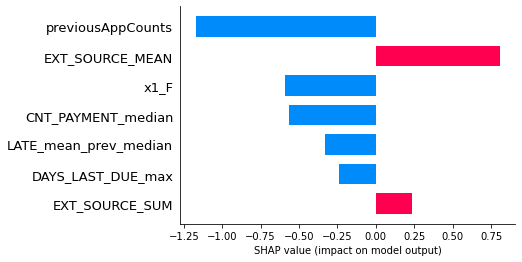

In [78]:
shap.bar_plot(shap_values[1][0],feature_names=over_X.columns,show=False)

In [79]:
f=plt.gcf()

<Figure size 432x288 with 0 Axes>

In [80]:
f.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


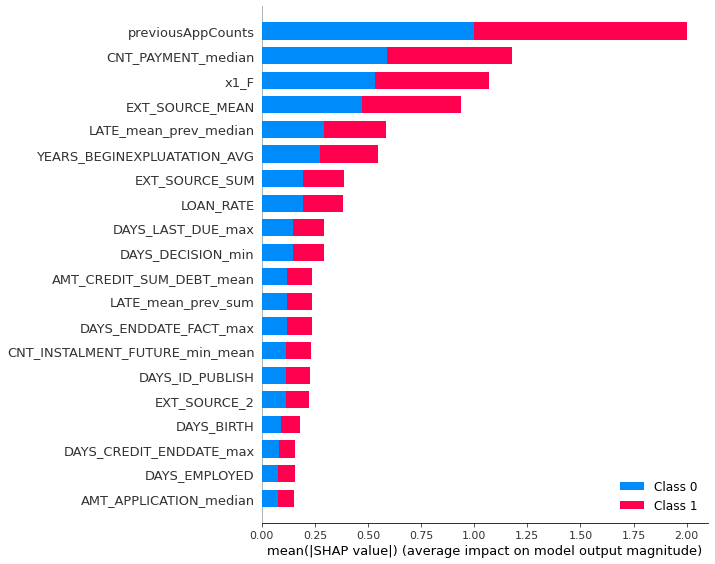

In [73]:
shap.summary_plot(shap_values,over_X,feature_names=over_X.columns)

# Modeling II

In [67]:
# installments = pd.read_csv('../input/installments_payments.csv').replace({365243: np.nan})
# https://machinelearningmastery.com/what-is-bayesian-optimization/
#https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
#https://towardsdatascience.com/bayesian-optimization-and-hyperparameter-tuning-6a22f14cb9fa

The correlation between previousLoanCounts and the TARGET is -0.0115
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


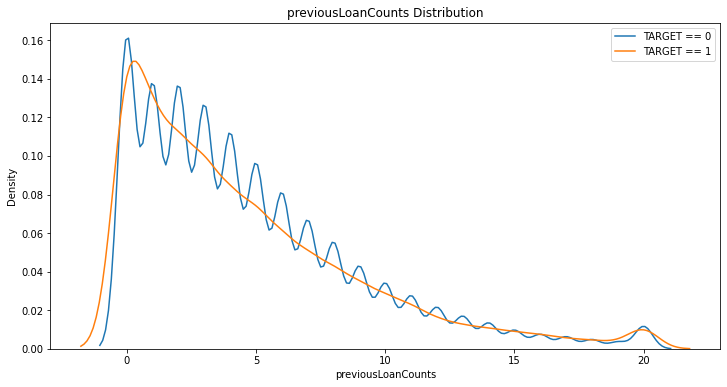

In [68]:
kde_target('previousLoanCounts', applicationTrain)

In [69]:
# LGBM, XGBOOST, CATBOOST, Logit

# hyper paramétrage (potentiellement sur google collab)

## Hyperparameters tuning

In [14]:
#batch sequences

In [5]:
applicationTrain=pd.read_csv('applicationTrain.csv', index_col = 0)
applicationTrain_y=np.ravel(pd.read_csv('applicationTrain_y.csv', index_col = 0))
applicationTrain_X=pd.read_csv('applicationTrain_X.csv', index_col = 0)

In [20]:
LGBMClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [6]:
def customMetric(y_true, y_pred, fn_value=-100, fp_value=-1, tp_value=10, tn_value=1):
    
    # Matrice de Confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # gain total
    g = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    # gain maximum
    g_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    # gain minimum
    g_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    # gain normalisé
    g_norm = (g - g_min)/(g_max - g_min)

    return g_norm

In [7]:
from hyperopt import hp
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import STATUS_OK

def hyperopt_train_test(params):
    
    # On s'assure que les paramètres soient au bon format
    for parameter_name in ['num_leaves','max_depth','n_estimators']:
        params[parameter_name] = int(params[parameter_name])

    # Paramètres du modèle    
    params_model = {'n_estimators': params['n_estimators'], 
                    'class_weight': params['class_weight'],
                    'max_depth': int(params['max_depth']), 
                    'learning_rate': params['learning_rate'],
                    'subsample': params['subsample'],
                    'colsample_bytree': params['colsample_bytree'],
                    'num_leaves': int(params['num_leaves']),
                    'reg_alpha': params['reg_alpha'],
                    'reg_lambda': params['reg_lambda']
                   }

    X_ = applicationTrain_X[:]
    
    skf = StratifiedKFold(n_splits=3)
    
    clf = LGBMClassifier(**params_model)
    
    y_pred = cross_val_predict(clf, X_, applicationTrain_y, method='predict', cv=skf)
    
    score = customMetric(applicationTrain_y, y_pred)
    
    loss = 1 - score
    
    return loss

space = {
    'n_estimators': hp.quniform('n_estimators', 200, 800, 200),
    #'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'max_depth' : hp.quniform('max_depth', 2, 30, 2),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
    #'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
    'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
    'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
    'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
}


best = 1

def f(params):
    global best
    loss = hyperopt_train_test(params)
    if loss < best:
        best = loss
        print ('new best:', best, params)
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()


best = fmin(f, space, algo=tpe.suggest, max_evals=5, trials=trials)

print('best:')
print(best)


  0%|                                                                                                                                                                                               | 0/5 [00:00<?, ?trial/s, best loss=?]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



new best:                                                                                                                                                                                                                                 
0.3251293489743402                                                                                                                                                                                                                        
{'class_weight': 'balanced', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.06830366370859095, 'max_depth': 22, 'n_estimators': 400, 'num_leaves': 24, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001, 'solvability_threshold': 0.8250000000000001, 'subsample': 0.6000000000000001}
 20%|████████████████████████████████▊                                                                                                                                   | 1/5 [01:53<07:32, 113.05s/trial, best loss: 0.3251293489743402]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 2/5 [06:11<07:49, 156.62s/trial, best loss: 0.3251293489743402]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 3/5 [07:59<04:44, 142.05s/trial, best loss: 0.3251293489743402]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4/5 [10:54<02:32, 152.03s/trial, best loss: 0.3251293489743402]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [15:49<00:00, 189.80s/trial, best loss: 0.3251293489743402]
best:
{'class_weight': 1, 'colsample_by_tree': 0.6000000000000001, 'learning_rate': 0.06830366370859095, 'max_depth': 22.0, 'n_estimators': 400.0, 'num_leaves': 24.0, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001, 'solvability_threshold': 0.8250000000000001, 'subsample': 0.6000000000000001}


In [19]:
model = modeling(LGBMClassifier(), applicationTrain_X, applicationTrain_y)

y_pred = model.predict(applicationTrain_X)

confusion_matrix(applicationTrain_y,y_pred)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

0.5132258474393429
0.9197587070339176


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	valid_0's auc: 0.711153	valid_0's binary_logloss: 0.27527
[2]	valid_0's auc: 0.719188	valid_0's binary_logloss: 0.271128
[3]	valid_0's auc: 0.721611	valid_0's binary_logloss: 0.267958
[4]	valid_0's auc: 0.723808	valid_0's binary_logloss: 0.265472
[5]	valid_0's auc: 0.726044	valid_0's binary_logloss: 0.263279
[6]	valid_0's auc: 0.727548	valid_0's binary_logloss: 0.261561
[7]	valid_0's auc: 0.728337	valid_0's binary_logloss: 0.260182
[8]	valid_0's auc: 0.729351	valid_0's binary_logloss: 0.258953
[9]	valid_0's auc: 0.730724	valid_0's binary_logloss: 0.257834
[10]	valid_0's auc: 0.73222	valid_0's binary_logloss: 0.256867
[11]	valid_0's auc: 0.733687	valid_0's binary_logloss: 0.256059
[12]	valid_0's auc: 0.735146	valid_0's binary_logloss: 0.255238
[13]	valid_0's auc: 0.735911	valid_0's binary_logloss: 0.25465
[14]	valid_0's auc: 0.737528	valid_0's binary_logloss: 0.253918
[15]	valid_0's auc: 0.738996	valid_0's binary_logloss: 0.253323
[16]	valid_0's auc: 0.740241	valid_0's binary_loglos

array([[282261,    425],
       [ 23765,   1060]], dtype=int64)

In [9]:
params = {'learning_rate': 0.06830366370859095, 'max_depth': 22, 'n_estimators': 400, 'num_leaves': 24, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001, 'subsample': 0.6000000000000001}

model = modeling(LGBMClassifier(**params), applicationTrain_X, applicationTrain_y)

y_pred = model.predict(applicationTrain_X)

confusion_matrix(applicationTrain_y,y_pred)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Unknown parameter: colsample_by_tree


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Unknown parameter: colsample_by_tree


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Unknown parameter: colsample_by_tree


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
0.5168492402871535
0.9194253845403402


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[1]	valid_0's auc: 0.717482	valid_0's binary_logloss: 0.274509
[2]	valid_0's auc: 0.721233	valid_0's binary_logloss: 0.271395
[3]	valid_0's auc: 0.724529	valid_0's binary_logloss: 0.268789
[4]	valid_0's auc: 0.726039	valid_0's binary_logloss: 0.266574
[5]	valid_0's auc: 0.726863	valid_0's binary_logloss: 0.264706
[6]	valid_0's auc: 0.727848	valid_0's binary_logloss: 0.263033
[7]	valid_0's auc: 0.728775	valid_0's binary_logloss: 0.261614
[8]	valid_0's auc: 0.730841	valid_0's binary_logloss: 0.260303
[9]	valid_0's auc: 0.732067	valid_0's binary_logloss: 0.259181
[10]	valid_0's auc: 0.733211	valid_0's binary_logloss: 0.258164
[11]	valid_0's auc: 0.734066	valid_0's binary_logloss: 0.257273
[12]	valid_0's auc: 0.734845	valid_0's binary_logloss: 0.256475
[13]	valid_0's auc: 0.735304	valid_0's binary_logloss: 0.255772
[14]	valid_0's auc: 0.735861	valid_0's binary_logloss: 0.255126
[15]	valid_0's auc: 0.736597	valid_0's binary_logloss: 

[129]	valid_0's auc: 0.777569	valid_0's binary_logloss: 0.239167
[130]	valid_0's auc: 0.777647	valid_0's binary_logloss: 0.239141
[131]	valid_0's auc: 0.777715	valid_0's binary_logloss: 0.239122
[132]	valid_0's auc: 0.777863	valid_0's binary_logloss: 0.239082
[133]	valid_0's auc: 0.778186	valid_0's binary_logloss: 0.238982
[134]	valid_0's auc: 0.778195	valid_0's binary_logloss: 0.238975
[135]	valid_0's auc: 0.778289	valid_0's binary_logloss: 0.238944
[136]	valid_0's auc: 0.77832	valid_0's binary_logloss: 0.238926
[137]	valid_0's auc: 0.778397	valid_0's binary_logloss: 0.238899
[138]	valid_0's auc: 0.778442	valid_0's binary_logloss: 0.238879
[139]	valid_0's auc: 0.778492	valid_0's binary_logloss: 0.238868
[140]	valid_0's auc: 0.778661	valid_0's binary_logloss: 0.238826
[141]	valid_0's auc: 0.778787	valid_0's binary_logloss: 0.238791
[142]	valid_0's auc: 0.778777	valid_0's binary_logloss: 0.238777
[143]	valid_0's auc: 0.778896	valid_0's binary_logloss: 0.238742
[144]	valid_0's auc: 0.779

[258]	valid_0's auc: 0.781589	valid_0's binary_logloss: 0.237807
[259]	valid_0's auc: 0.781576	valid_0's binary_logloss: 0.237818
[260]	valid_0's auc: 0.781667	valid_0's binary_logloss: 0.237798
[261]	valid_0's auc: 0.781703	valid_0's binary_logloss: 0.237792
[262]	valid_0's auc: 0.781648	valid_0's binary_logloss: 0.237803
[263]	valid_0's auc: 0.781654	valid_0's binary_logloss: 0.237807
[264]	valid_0's auc: 0.781638	valid_0's binary_logloss: 0.237816
[265]	valid_0's auc: 0.781605	valid_0's binary_logloss: 0.237827
[266]	valid_0's auc: 0.78158	valid_0's binary_logloss: 0.237832
[267]	valid_0's auc: 0.781593	valid_0's binary_logloss: 0.237825
[268]	valid_0's auc: 0.781598	valid_0's binary_logloss: 0.23782
[269]	valid_0's auc: 0.781566	valid_0's binary_logloss: 0.237827
[270]	valid_0's auc: 0.781515	valid_0's binary_logloss: 0.237833
[271]	valid_0's auc: 0.781507	valid_0's binary_logloss: 0.237832
[272]	valid_0's auc: 0.781451	valid_0's binary_logloss: 0.237841
[273]	valid_0's auc: 0.7814

[385]	valid_0's auc: 0.78192	valid_0's binary_logloss: 0.237585
[386]	valid_0's auc: 0.781931	valid_0's binary_logloss: 0.237583
[387]	valid_0's auc: 0.781955	valid_0's binary_logloss: 0.237576
[388]	valid_0's auc: 0.781949	valid_0's binary_logloss: 0.23758
[389]	valid_0's auc: 0.782004	valid_0's binary_logloss: 0.237563
[390]	valid_0's auc: 0.782039	valid_0's binary_logloss: 0.23755
[391]	valid_0's auc: 0.782056	valid_0's binary_logloss: 0.237548
[392]	valid_0's auc: 0.782012	valid_0's binary_logloss: 0.237556
[393]	valid_0's auc: 0.782017	valid_0's binary_logloss: 0.237557
[394]	valid_0's auc: 0.782057	valid_0's binary_logloss: 0.237545
[395]	valid_0's auc: 0.782081	valid_0's binary_logloss: 0.237544
[396]	valid_0's auc: 0.782132	valid_0's binary_logloss: 0.237537
[397]	valid_0's auc: 0.782094	valid_0's binary_logloss: 0.237543
[398]	valid_0's auc: 0.78209	valid_0's binary_logloss: 0.23755
[399]	valid_0's auc: 0.782111	valid_0's binary_logloss: 0.237542
[400]	valid_0's auc: 0.782079	

array([[282188,    498],
       [ 23332,   1493]], dtype=int64)

In [ ]:
# Matrice de confusion hyperparamètre avec métrique normal
# Matrice de confusion hyperparamètre avec métrique opti

In [66]:
# Selection de features (RFECV)

In [68]:
# https://www.aquiladata.fr/insights/interpretabilite-des-modeles-de-machine-learning/

#SHAPASH

In [35]:
#remove SK ID CURR for training

## test

In [46]:
applicationTest = pd.merge(applicationTest,preprocess(previousApplication,aggregation=True,_id="SK_ID_CURR"), how = "left",left_on="SK_ID_CURR",right_on="SK_ID_CURR",suffixes=("_curr","_prev"))

In [ ]:
applicationTest = pd.merge(applicationTest,preprocess(bureau,aggregation=True,_id="SK_ID_CURR"), how = "left",left_on="SK_ID_CURR",right_on="SK_ID_CURR",suffixes=("_curr","_bureau"))

In [ ]:
applicationTest=preprocess(applicationTest)

In [ ]:
applicationTest_X=applicationTest.drop(columns=["SK_ID_CURR"])

In [ ]:
colTest=[col for col in applicationTest.columns if col in under_X.columns[feat_selector.support_]]

In [ ]:
applicationTest=applicationTest[colTest]

In [ ]:
sampleSubmission["TARGET"]=1-model.predict_proba(applicationTest)

In [ ]:
sampleSubmission.to_csv(r'data\sample_submission.csv', index = False)

orderReviews["length_comment_title"] = orderReviews["review_comment_title"].map(lambda x : len(x) if str(x)!="nan" else 0)
orderReviews["length_comment_message"] = orderReviews["review_comment_message"].map(lambda x : len(x) if str(x)!="nan" else 0)

orderReviews["has_comment_title"] = orderReviews["length_comment_title"].map(lambda x : 1 if x>0 else 0)
orderReviews["has_comment_message"] = orderReviews["length_comment_message"].map(lambda x : 1 if x>0 else 0)

orderReviews["satisfied"]=orderReviews["review_score"].map(lambda x : 1 if x>2 else -1)

orderReviews["analysis_comment_title"] = orderReviews["length_comment_title"]*orderReviews["satisfied"]
orderReviews["analysis_comment_message"] = orderReviews["length_comment_message"]*orderReviews["satisfied"]

products["product_volume"]=products["product_length_cm"]*products["product_width_cm"]*products["product_height_cm"]

nb_items=orderItems.groupby(by="order_id",sort=False)["order_item_id"].max()

sellers=orderItems.groupby(by="order_id",sort=False)["seller_id"].apply(list)

tot_price=orderItems.groupby(by="order_id",sort=False)["price"].sum()

tot_freight=orderItems.groupby(by="order_id",sort=False)["freight_value"].sum()

tot_name_length = orderItems.groupby(by="order_id",sort=False)["product_name_lenght"].sum()

tot_description_length = orderItems.groupby(by="order_id",sort=False)["product_description_lenght"].sum()

tot_photos_qty = orderItems.groupby(by="order_id",sort=False)["product_photos_qty"].sum()

tot_product_weight = orderItems.groupby(by="order_id",sort=False)["product_weight_g"].sum()

product_category=orderItems.groupby(by="order_id",sort=False)["product_category_name_english"].apply(list)

tot_product_volume = orderItems.groupby(by="order_id",sort=False)["product_volume"].sum()

seller_lat = orderItems.groupby(by="order_id",sort=False)["geolocation_lat"].apply(list)

seller_lng = orderItems.groupby(by="order_id",sort=False)["geolocation_lng"].apply(list)

seller_city = orderItems.groupby(by="order_id",sort=False)["geolocation_city"].apply(list)

seller_state = orderItems.groupby(by="order_id",sort=False)["geolocation_state"].apply(list)

orderItemsFE=pd.DataFrame({"sellers_list":sellers,"sellers_city_list":seller_city,"sellers_state_list":seller_state,
                   "sellers_lat_list":seller_lat,"sellers_lng_list":seller_lng,
                   "nb_produts":nb_items,"TOT_price":tot_price,"TOT_freight":tot_freight,
                   "TOT_name_length":tot_name_length,"TOT_desc_length":tot_description_length,
                   "TOT_photo_qty":tot_photos_qty,"TOT_product_weight":tot_product_weight,
                   "TOT_product_volume":tot_product_volume,"product_category_list":product_category})

orderItemsFE=orderItemsFE.reset_index()

installments = orderPayments["payment_installments"]
value = orderPayments["payment_value"]
l = len(value)
monthly_installment = []
for i in range(l):
    if installments[i] != 0 :
        monthly_installment.extend([value[i]/installments[i]])
    else :
        monthly_installment.extend([0])

orderPayments["monthly_installments"] = monthly_installment

sequentialMax=orderPayments.groupby(by="order_id",sort=False)["payment_sequential"].max()

paymentType=orderPayments.groupby(by="order_id",sort=False)["payment_type"].apply(list)

paymentInstallment=orderPayments.groupby(by=["order_id","payment_type"],sort=False)["payment_installments"].apply(list)

monthlyInstallment=orderPayments.groupby(by=["order_id","payment_type"],sort=False)["monthly_installments"].apply(list)

totalValue=orderPayments.groupby(by="order_id",sort=False)["payment_value"].sum()

valueType=orderPayments.groupby(by=["order_id","payment_type"],sort=False)["payment_value"].apply(list)

orderPaymentsFE=pd.DataFrame({"sequential_max":sequentialMax, "payment_type":paymentType,"payment_value_total":totalValue})

orderPaymentsFE["nbCredit_card"]=orderPaymentsFE["payment_type"].map(lambda x : x.count("credit_card"))
orderPaymentsFE["nbBoleto"]=orderPaymentsFE["payment_type"].map(lambda x : x.count("boleto"))
orderPaymentsFE["nbVoucher"]=orderPaymentsFE["payment_type"].map(lambda x : x.count("voucher"))
orderPaymentsFE["nbDebit_card"]=orderPaymentsFE["payment_type"].map(lambda x : x.count("debit_card"))
orderPaymentsFE["nb_payment"]=orderPaymentsFE["nbCredit_card"]+orderPaymentsFE["nbBoleto"]+orderPaymentsFE["nbVoucher"]+orderPaymentsFE["nbDebit_card"]

installment_credit=[]
for orderId in orderPaymentsFE.index:
    try:
        installment_credit.extend([sum(paymentInstallment[orderId,"credit_card"])])
    except KeyError :
        installment_credit.extend([0])

orderPaymentsFE["nbInstallment_credit"]=installment_credit

tot_monthly_installment=[]
for orderId in orderPaymentsFE.index:
    try:
        tot_monthly_installment.extend([sum(monthlyInstallment[orderId,"credit_card"])])
    except KeyError :
        tot_monthly_installment.extend([0])

orderPaymentsFE["TOT_value_monthly_installment"]=tot_monthly_installment

value_credit=[]
value_boleto=[]
value_voucher=[]
value_debit=[]
for orderId in orderPaymentsFE.index:
    try:
        value_credit.extend([sum(valueType[orderId,"credit_card"])])
    except KeyError :
        value_credit.extend([0])
    try:
        value_boleto.extend([sum(valueType[orderId,"boleto"])])
    except KeyError :
        value_boleto.extend([0])
    try:
        value_voucher.extend([sum(valueType[orderId,"voucher"])])
    except KeyError :
        value_voucher.extend([0])
    try:
        value_debit.extend([sum(valueType[orderId,"debit_card"])])
    except KeyError :
        value_debit.extend([0])

orderPaymentsFE["TOT_value_credit"]=value_credit
orderPaymentsFE["TOT_value_boleto"]=value_boleto
orderPaymentsFE["TOT_value_voucher"]=value_voucher
orderPaymentsFE["TOT_value_debit"]=value_debit

orderPaymentsFE.drop(columns=["sequential_max","payment_type","payment_value_total"],inplace=True)

orderPaymentsFE=orderPaymentsFE.reset_index()

customers["order_purchase_timestamp"]=customers["order_purchase_timestamp"].map(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
customers["order_delivered_customer_date"]=customers["order_delivered_customer_date"].map(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
customers["order_estimated_delivery_date"]=customers["order_estimated_delivery_date"].map(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
customers["review_creation_date"]=customers["review_creation_date"].map(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
customers["review_answer_timestamp"]=customers["review_answer_timestamp"].map(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())

#### creation of features

customers["expected_waited_days"]=customers.apply(timeDiffDays,end="order_estimated_delivery_date",start="order_purchase_timestamp",axis=1)

customers["waited_days"]=customers.apply(timeDiffDays,end="order_delivered_customer_date",start="order_purchase_timestamp",axis=1)

customers["relative_waited_days"]=(customers["expected_waited_days"]-customers["waited_days"])/customers["expected_waited_days"]

customers["happiness_waited_days"]=customers["relative_waited_days"]*np.log(0.01+customers["waited_days"])

## Etude de stabilité  

In [116]:
x=distributionAgg.keys()
c=distributionAgg[0].keys()

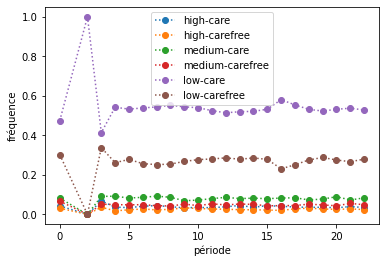

In [117]:
for rfmClass in c:
    y=[]
    for period in x: 
        y.append(distributionAgg[period][rfmClass])
    plt.plot(x, y, "o:", label=rfmClass)
plt.xlabel("période")
plt.ylabel("fréquence")
plt.legend()
plt.show()

# Features for ML 

In [ ]:
customers.head(100)

In [123]:
customers.sellers_list

0        [7c67e1448b00f6e969d365cea6b010ab]
1        [b8bc237ba3788b23da09c0f1f3a3288c]
2        [7c67e1448b00f6e969d365cea6b010ab]
3        [7c67e1448b00f6e969d365cea6b010ab]
4        [4a3ca9315b744ce9f8e9374361493884]
                        ...                
96473    [527801b552d0077ffd170872eb49683b]
96474    [3fd1e727ba94cfe122d165e176ce7967]
96475    [d9e7e7778b32987280a6f2cb9a39c57d]
96476    [4869f7a5dfa277a7dca6462dcf3b52b2]
96477    [3c7c4a49ec3c6550809089c6a2ca9370]
Name: sellers_list, Length: 96469, dtype: object

In [132]:
sellers_l=[]
for sellers in customers.sellers_list:
    sellers_l.extend(sellers)

In [ ]:
sellers_set=set(sellers_l)

In [149]:
sellers_count={}

for seller in sellers_set:
    sellers_count[seller]=sellers_l.count(seller)

In [150]:
sellers_count

{'45d33f715e24d15a6ccf5c17b3a23e3c': 58,
 '4049512728d969bec69f84088b012416': 9,
 'a00824eb9093d40e589b940ec45c4eb0': 3,
 '7fe21dd00d2f4943ae09525efa2fd674': 2,
 'fa8d335d68129e464e60c1826a683e96': 1,
 '5a9b3bcab695173c820e53934574ae80': 1,
 '436bf27f2f18474fc6047702e9f8a866': 1,
 'e21a1e8be4715b0fcfd5385643bc49c4': 23,
 '4e06067cc08b3f41d837768d392c3ee3': 46,
 '5ef131ac72773e5b3f6c0d63cf424657': 11,
 'ad420dd0c4f92f8af951ac24b86d0cf5': 46,
 '7238f877570096ae403c51898fa64566': 3,
 'e64d65bc8dbec2accda90c58de5d1246': 12,
 '4e42581f08e8cfc7c090f930bac4552a': 2,
 '52bb00821bcdd358a5a5a27e1f6be5a1': 2,
 '406822777a0b9eb5c50e442dd4cd3ec5': 46,
 'fc4751cfe3b279c419615b9b00c1abb4': 1,
 '8cc6a0e5738e61a87b03c78b2ba9db4b': 24,
 '3d700782d7818f2c1e0d7a9e9d75fc00': 3,
 '9646c3513289980f17226a2fc4720dbd': 76,
 'b0398568231ba5e6734af1881671a317': 4,
 'c4f7fee5b0db50e87766f5a4d1b1b758': 5,
 'd354c38a7182125a748cb10474fe963b': 19,
 'd4e12e7884759a14fa0f5f896c791cae': 32,
 'd73cbd89533ce8b041a91902414

In [158]:
sellers_10=sorted(sellers_count.items(), key=lambda t: t[1], reverse=True)[:10]

In [174]:
sellers_10_id={x[0]:sellers_10.index(x) for x in sellers_10}

In [181]:
sellers_10_id

{'6560211a19b47992c3666cc44a7e94c0': 0,
 '4a3ca9315b744ce9f8e9374361493884': 1,
 '1f50f920176fa81dab994f9023523100': 2,
 'cc419e0650a3c5ba77189a1882b7556a': 3,
 'da8622b14eb17ae2831f4ac5b9dab84a': 4,
 '955fee9216a65b617aa5c0531780ce60': 5,
 '1025f0e2d44d7041d6cf58b6550e0bfa': 6,
 '7c67e1448b00f6e969d365cea6b010ab': 7,
 'ea8482cd71df3c1969d7b9473ff13abc': 8,
 '7a67c85e85bb2ce8582c35f2203ad736': 9}

In [176]:
sellers_rank=[]

In [183]:
for x in customers.sellers_list:
    if len(x)=1:
        if x in sellers_10_id.keys():
            sellers_rank.extend(sellers_10_id[x])
        else:
            sellers_rank.extend(10)
    else:
        for

TypeError: unhashable type: 'list'

# Analyse exploratoire 

## Analyse bivariée

In [134]:
customers_uniques.info()

AttributeError: 'dict' object has no attribute 'info'

<AxesSubplot:>

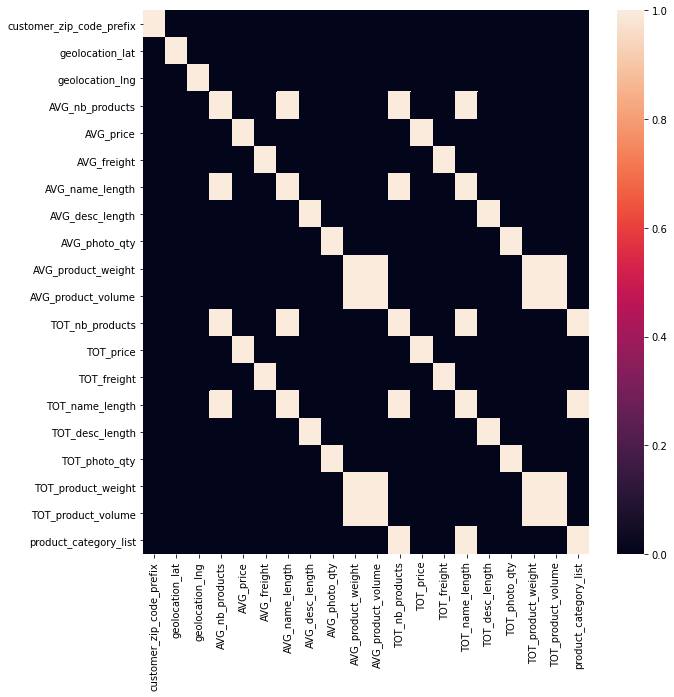

In [200]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(np.abs(customers_unique.iloc[:,:25].corr())>0.7, ax=ax)

In [201]:
customers_unique=customers_unique.drop(columns=["TOT_nb_products",
                        "TOT_price","TOT_freight","TOT_name_length","TOT_desc_length","TOT_photo_qty",
                        "TOT_product_weight","TOT_product_volume",
                        "AVG_product_volume","AVG_name_length"])

<AxesSubplot:>

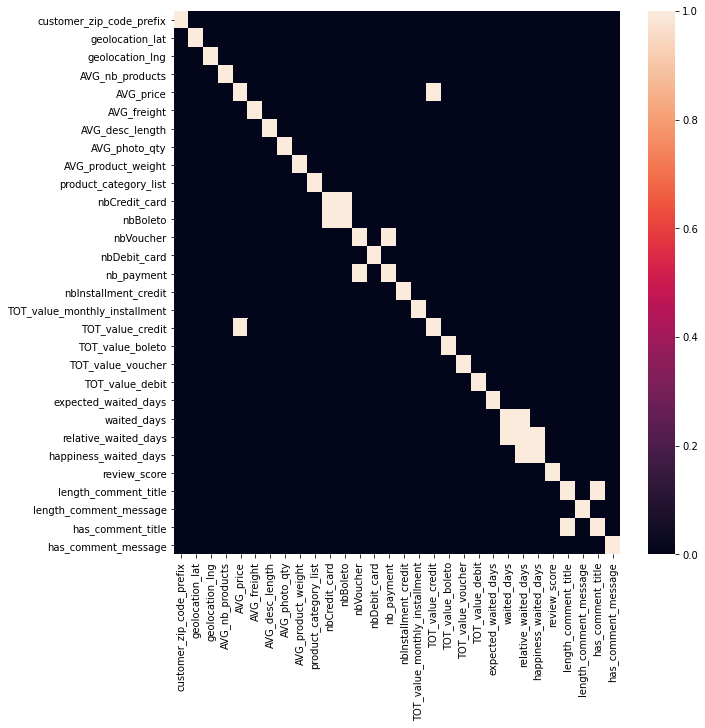

In [202]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(np.abs(customers_unique.iloc[:,:35].corr())>0.7, ax=ax)

In [203]:
customers_unique=customers_unique.drop(columns=["TOT_value_credit","nbCredit_card","nb_payment","relative_waited_days",
                                                "has_comment_title"])

<AxesSubplot:>

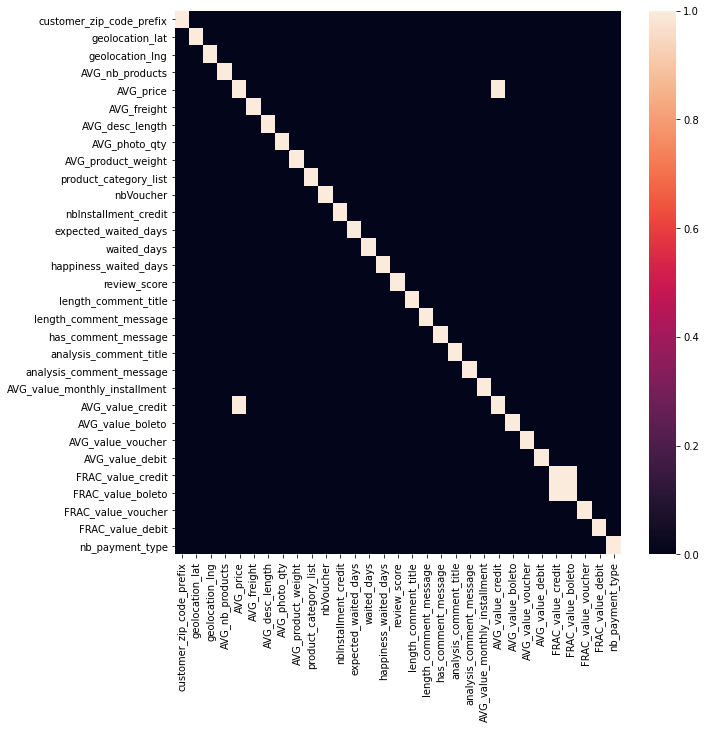

In [206]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(np.abs(customers_unique.iloc[:,:50].corr())>0.7, ax=ax)

In [205]:
customers_unique=customers_unique.drop(columns=["nbBoleto","nbDebit_card",
                                                "TOT_value_monthly_installment",
                                                "TOT_value_boleto","TOT_value_voucher","TOT_value_debit",
                                                "satisfied",
                                                "credit_card","boleto","voucher","debit_card"])

<AxesSubplot:>

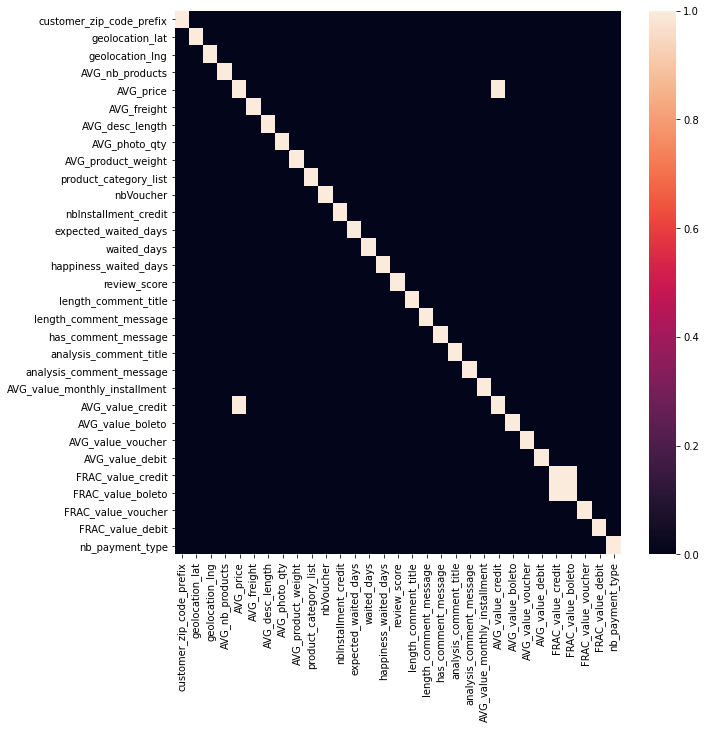

In [207]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(np.abs(customers_unique.corr())>0.7, ax=ax)

In [208]:
customers_unique=customers_unique.drop(columns=["AVG_value_credit","FRAC_value_boleto"])

<AxesSubplot:>

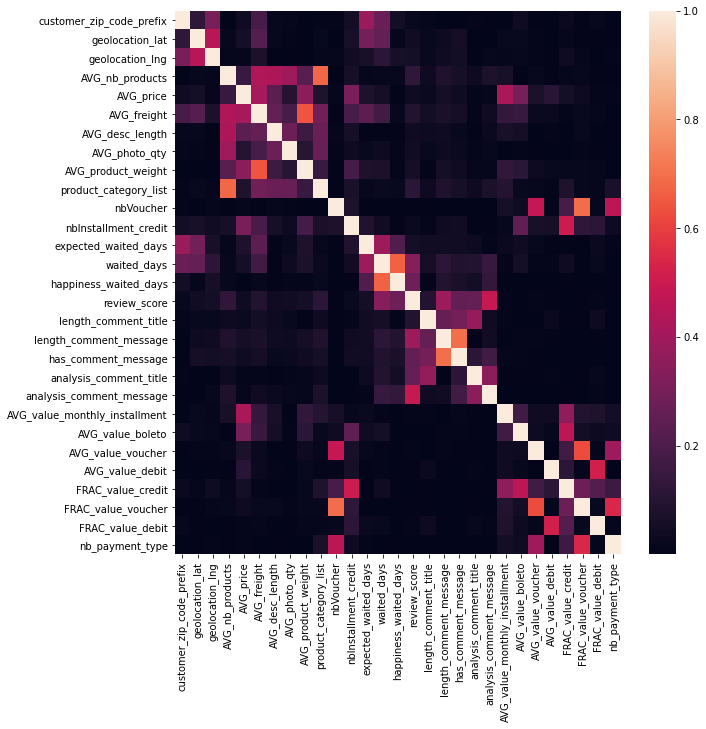

In [209]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(np.abs(customers_unique.corr()), ax=ax)

# Approche ML

## Préparation des données

#### winsorize & log

In [210]:
#sns.boxplot(x=orderItems["freight_valueLog"])

In [211]:
#sns.displot(data=orderItems, x="freight_valueLog", kind="kde")

In [118]:
customers_unique["AVG_price"]=np.log(1+customers_unique["AVG_price"])

customers_unique["AVG_freight"]=np.log(1+customers_unique["AVG_freight"])

customers_unique["AVG_desc_length"]=np.log(1+customers_unique["AVG_desc_length"])

customers_unique["AVG_product_weight"]=np.log(1+customers_unique["AVG_product_weight"])

customers_unique["AVG_photo_qty"]=np.log(1+customers_unique["AVG_photo_qty"])

customers_unique["AVG_value_monthly_installment"]=np.log(1+customers_unique["AVG_value_monthly_installment"])

customers_unique["AVG_value_boleto"]=np.log(1+customers_unique["AVG_value_boleto"])

customers_unique["AVG_value_voucher"]=np.log(1+customers_unique["AVG_value_voucher"])

customers_unique["AVG_value_debit"]=np.log(1+customers_unique["AVG_value_debit"])


customers_unique["nbInstallment_credit"]=winsorize(customers_unique["nbInstallment_credit"],limits=[0.01,0.01])
customers_unique["expected_waited_days"]=winsorize(customers_unique["expected_waited_days"],limits=[0.01,0.01])
customers_unique["waited_days"]=winsorize(customers_unique["waited_days"],limits=[0.01,0.01])
customers_unique["happiness_waited_days"]=winsorize(customers_unique["happiness_waited_days"],limits=[0.01,0.01])

NameError: name 'customers_unique' is not defined

#### scaling

In [498]:
customers_unique=customers_unique.drop(columns=["customer_zip_code_prefix","geolocation_lat","geolocation_lng"])

In [499]:
var=getVarByTypes(customers_unique,["int64","float64"])

In [500]:
scaler = StandardScaler()
scaler.fit(customers_unique[var])

StandardScaler()

In [501]:
customers_unique[var]=scaler.transform(customers_unique[var])

In [502]:
customers_unique

,customer_unique_id,geolocation_city,geolocation_state,first_purchase_date,recency,AVG_nb_products,AVG_price,AVG_freight,AVG_name_length,AVG_desc_length,AVG_photo_qty,AVG_product_weight,AVG_product_volume,last_purchase_date,TOT_nb_products,TOT_price,TOT_freight,TOT_name_length,TOT_desc_length,TOT_photo_qty,TOT_product_weight,TOT_product_volume,product_category_list,nbCredit_card,nbBoleto,nbVoucher,nbDebit_card,nb_payment,nbInstallment_credit,TOT_value_monthly_installment,TOT_value_credit,TOT_value_boleto,TOT_value_voucher,TOT_value_debit,expected_waited_days,waited_days,relative_waited_days,happiness_waited_days,review_score,length_comment_title,length_comment_message,has_comment_title,has_comment_message,satisfied,analysis_comment_title,analysis_comment_message,AVG_value_monthly_installment,AVG_value_credit,AVG_value_boleto,AVG_value_voucher,AVG_value_debit,FRAC_value_credit,FRAC_value_boleto,FRAC_value_voucher,FRAC_value_debit,credit_card,boleto,voucher,debit_card,nb_payment_type
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,2017-05-16,1.526533,-0.264718,0.407540,0.256529,-0.485480,0.594028,-0.856511,1.684510,2.991133,2017-05-16,-0.290513,-0.077099,-0.073198,-0.481668,0.233957,-0.663898,1.259891,2.858403,-0.366056,0.53407,-0.49975,-0.139351,-0.125872,-0.120724,-0.238911,0.283793,0.101722,-0.258151,-0.123727,-0.063826,-0.515207,-0.398727,0.193969,0.338200,-0.108431,-0.319623,-0.585179,-0.366862,-0.837355,0.391589,-0.154065,-0.141541,0.853761,0.175421,-0.491713,-0.19523,-0.124272,0.600425,-0.496502,-0.185598,-0.125051,0.5442,-0.50079,-0.200019,-0.126445,-0.163149
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,2018-01-12,-0.056485,-0.264718,1.320250,1.572474,-0.415303,0.475991,0.554821,1.799592,1.201355,2018-01-12,-0.290513,0.683256,1.006645,-0.420734,0.089190,0.180167,1.557193,1.136974,-0.366056,0.53407,-0.49975,-0.139351,-0.125872,-0.120724,1.882175,-0.073249,1.017130,-0.258151,-0.123727,-0.063826,0.089178,0.555238,-0.431253,-0.064152,0.665466,-0.319623,-0.585179,-0.366862,-0.837355,0.391589,-0.154065,-0.141541,0.533303,1.178997,-0.491713,-0.19523,-0.124272,0.600425,-0.496502,-0.185598,-0.125051,0.5442,-0.50079,-0.200019,-0.126445,-0.163149
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,2018-05-19,-0.890689,-0.264718,0.530302,-0.098463,0.005756,0.432342,-0.856511,1.648317,0.953818,2018-05-19,-0.290513,-0.007790,-0.252732,-0.055129,0.040240,-0.663898,1.175584,0.898890,-0.366056,0.53407,-0.49975,-0.139351,-0.125872,-0.120724,1.528661,-0.293166,0.154430,-0.258151,-0.123727,-0.063826,0.089178,1.628449,-1.409862,-1.444724,0.665466,-0.319623,-0.585179,-0.366862,-0.837355,0.391589,-0.154065,-0.141541,0.183113,0.233206,-0.491713,-0.19523,-0.124272,0.600425,-0.496502,-0.185598,-0.125051,0.5442,-0.50079,-0.200019,-0.126445,-0.163149
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,2018-03-13,-0.457165,-0.264718,0.605348,0.369512,-0.239862,0.532247,-0.856511,1.932790,2.086252,2018-03-13,-0.290513,0.038570,-0.008231,-0.268399,0.155845,-0.663898,1.964540,1.988078,-0.366056,0.53407,-0.49975,-0.139351,-0.125872,-0.120724,-0.592426,1.415730,0.229998,-0.258151,-0.123727,-0.063826,0.451809,0.316747,-0.039033,0.402805,0.665466,-0.319623,-0.585179,-0.366862,-0.837355,0.391589,-0.154065,-0.141541,1.349295,0.316052,-0.491713,-0.19523,-0.124272,0.600425,-0.496502,-0.185598,-0.125051,0.5442,-0.50079,-0.200019,-0.126445,-0.163149
4,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,2018-07-29,-1.350486,-0.264718,1.071224,0.285445,0.216286,-0.342069,-0.856511,1.306557,0.209642,2018-07-29,-0.290513,0.409730,-0.056956,0.127673,-0.530497,-0.663898,0.554026,0.183134,-0.366056,0.53407,-0.49975,-0.139351,-0.125872,-0.120724,1.882175,-0.191172,0.613178,-0.258151,-0.123727,-0.063826,-0.877838,-0.160236,-0.341707,-0.144258,0.665466,2.651511,0.347824,2.749243,1.202224,0.391589,2.711943,0.673332,0.371695,0.736138,-0.491713,-0.19523,-0.124272,0.600425,-0.496502,-0.185598,-0.125051,0.5442,-0.50079,-0.200019,-0.126445,-0.163149
...,...,...,...,...,...,.

## ACP pour visualisation

In [503]:
data=customers_unique[var]

In [504]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93349 entries, 0 to 93348
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   recency                        93349 non-null  float64
 1   AVG_nb_products                93349 non-null  float64
 2   AVG_price                      93349 non-null  float64
 3   AVG_freight                    93349 non-null  float64
 4   AVG_name_length                93349 non-null  float64
 5   AVG_desc_length                93349 non-null  float64
 6   AVG_photo_qty                  93349 non-null  float64
 7   AVG_product_weight             93349 non-null  float64
 8   AVG_product_volume             93349 non-null  float64
 9   TOT_nb_products                93349 non-null  float64
 10  TOT_price                      93349 non-null  float64
 11  TOT_freight                    93349 non-null  float64
 12  TOT_name_length                93349 non-null 

In [505]:
data=data.drop(columns=["nbCredit_card","nbBoleto","nbVoucher","nbDebit_card","nb_payment",
                        "TOT_value_monthly_installment",
                        "TOT_value_credit","TOT_value_boleto","TOT_value_voucher","TOT_value_debit",
                        "AVG_value_credit","AVG_value_boleto","AVG_value_voucher","AVG_value_debit",
                        "FRAC_value_credit","FRAC_value_boleto","FRAC_value_voucher","FRAC_value_debit","nbInstallment_credit","AVG_value_monthly_installment",
                        "credit_card","boleto","voucher","debit_card",
                        "TOT_nb_products",
                        "TOT_price","TOT_freight","TOT_name_length","TOT_desc_length","TOT_photo_qty",
                        "TOT_product_weight","TOT_product_volume",
                        "AVG_product_volume",
                        "length_comment_title","length_comment_message","has_comment_title","has_comment_message",
                        "satisfied",
                        "relative_waited_days"])

In [506]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93349 entries, 0 to 93348
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   recency                   93349 non-null  float64
 1   AVG_nb_products           93349 non-null  float64
 2   AVG_price                 93349 non-null  float64
 3   AVG_freight               93349 non-null  float64
 4   AVG_name_length           93349 non-null  float64
 5   AVG_desc_length           93349 non-null  float64
 6   AVG_photo_qty             93349 non-null  float64
 7   AVG_product_weight        93349 non-null  float64
 8   product_category_list     93349 non-null  float64
 9   expected_waited_days      93349 non-null  float64
 10  waited_days               93349 non-null  float64
 11  happiness_waited_days     93349 non-null  float64
 12  review_score              93349 non-null  float64
 13  analysis_comment_title    93349 non-null  float64
 14  analys

In [507]:
n_comp = 6

# préparation des données pour l'ACP
X = data.values
names = data.index 
features = data.columns

In [508]:
pca = PCA(n_components=n_comp,svd_solver="arpack")

In [509]:
pca.fit(X)

PCA(n_components=6, svd_solver='arpack')

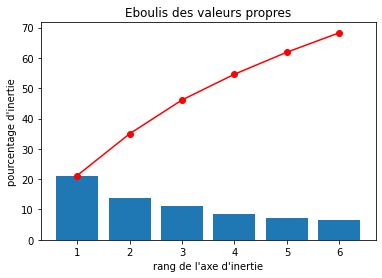

In [510]:
# Eboulis des valeurs propres1
display_scree_plot(pca)

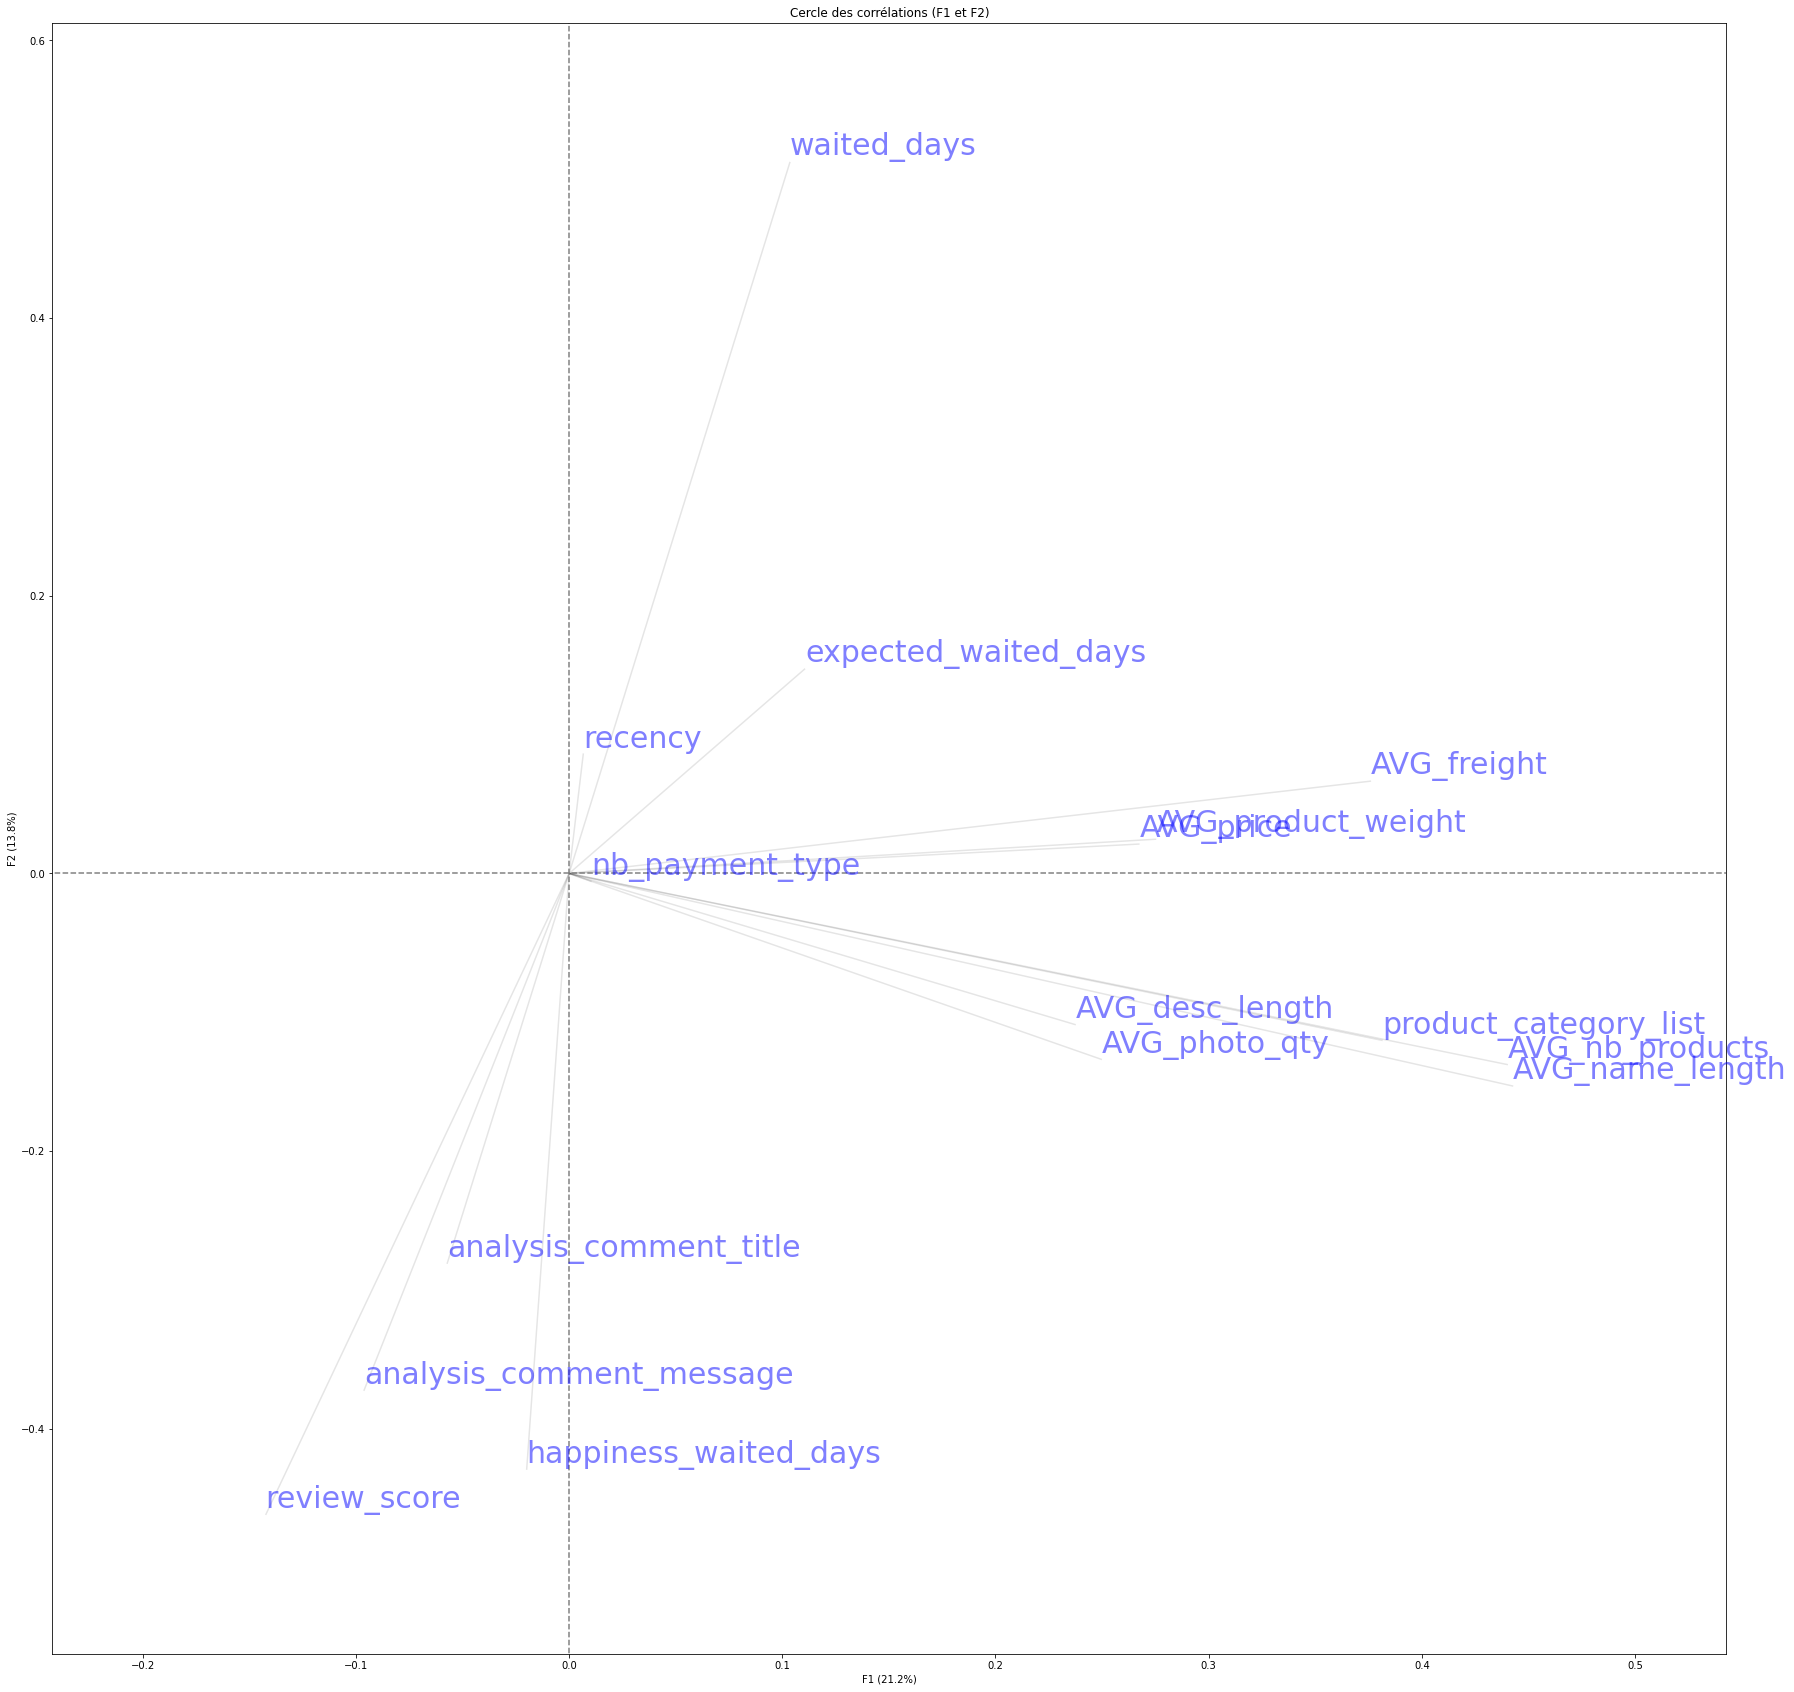

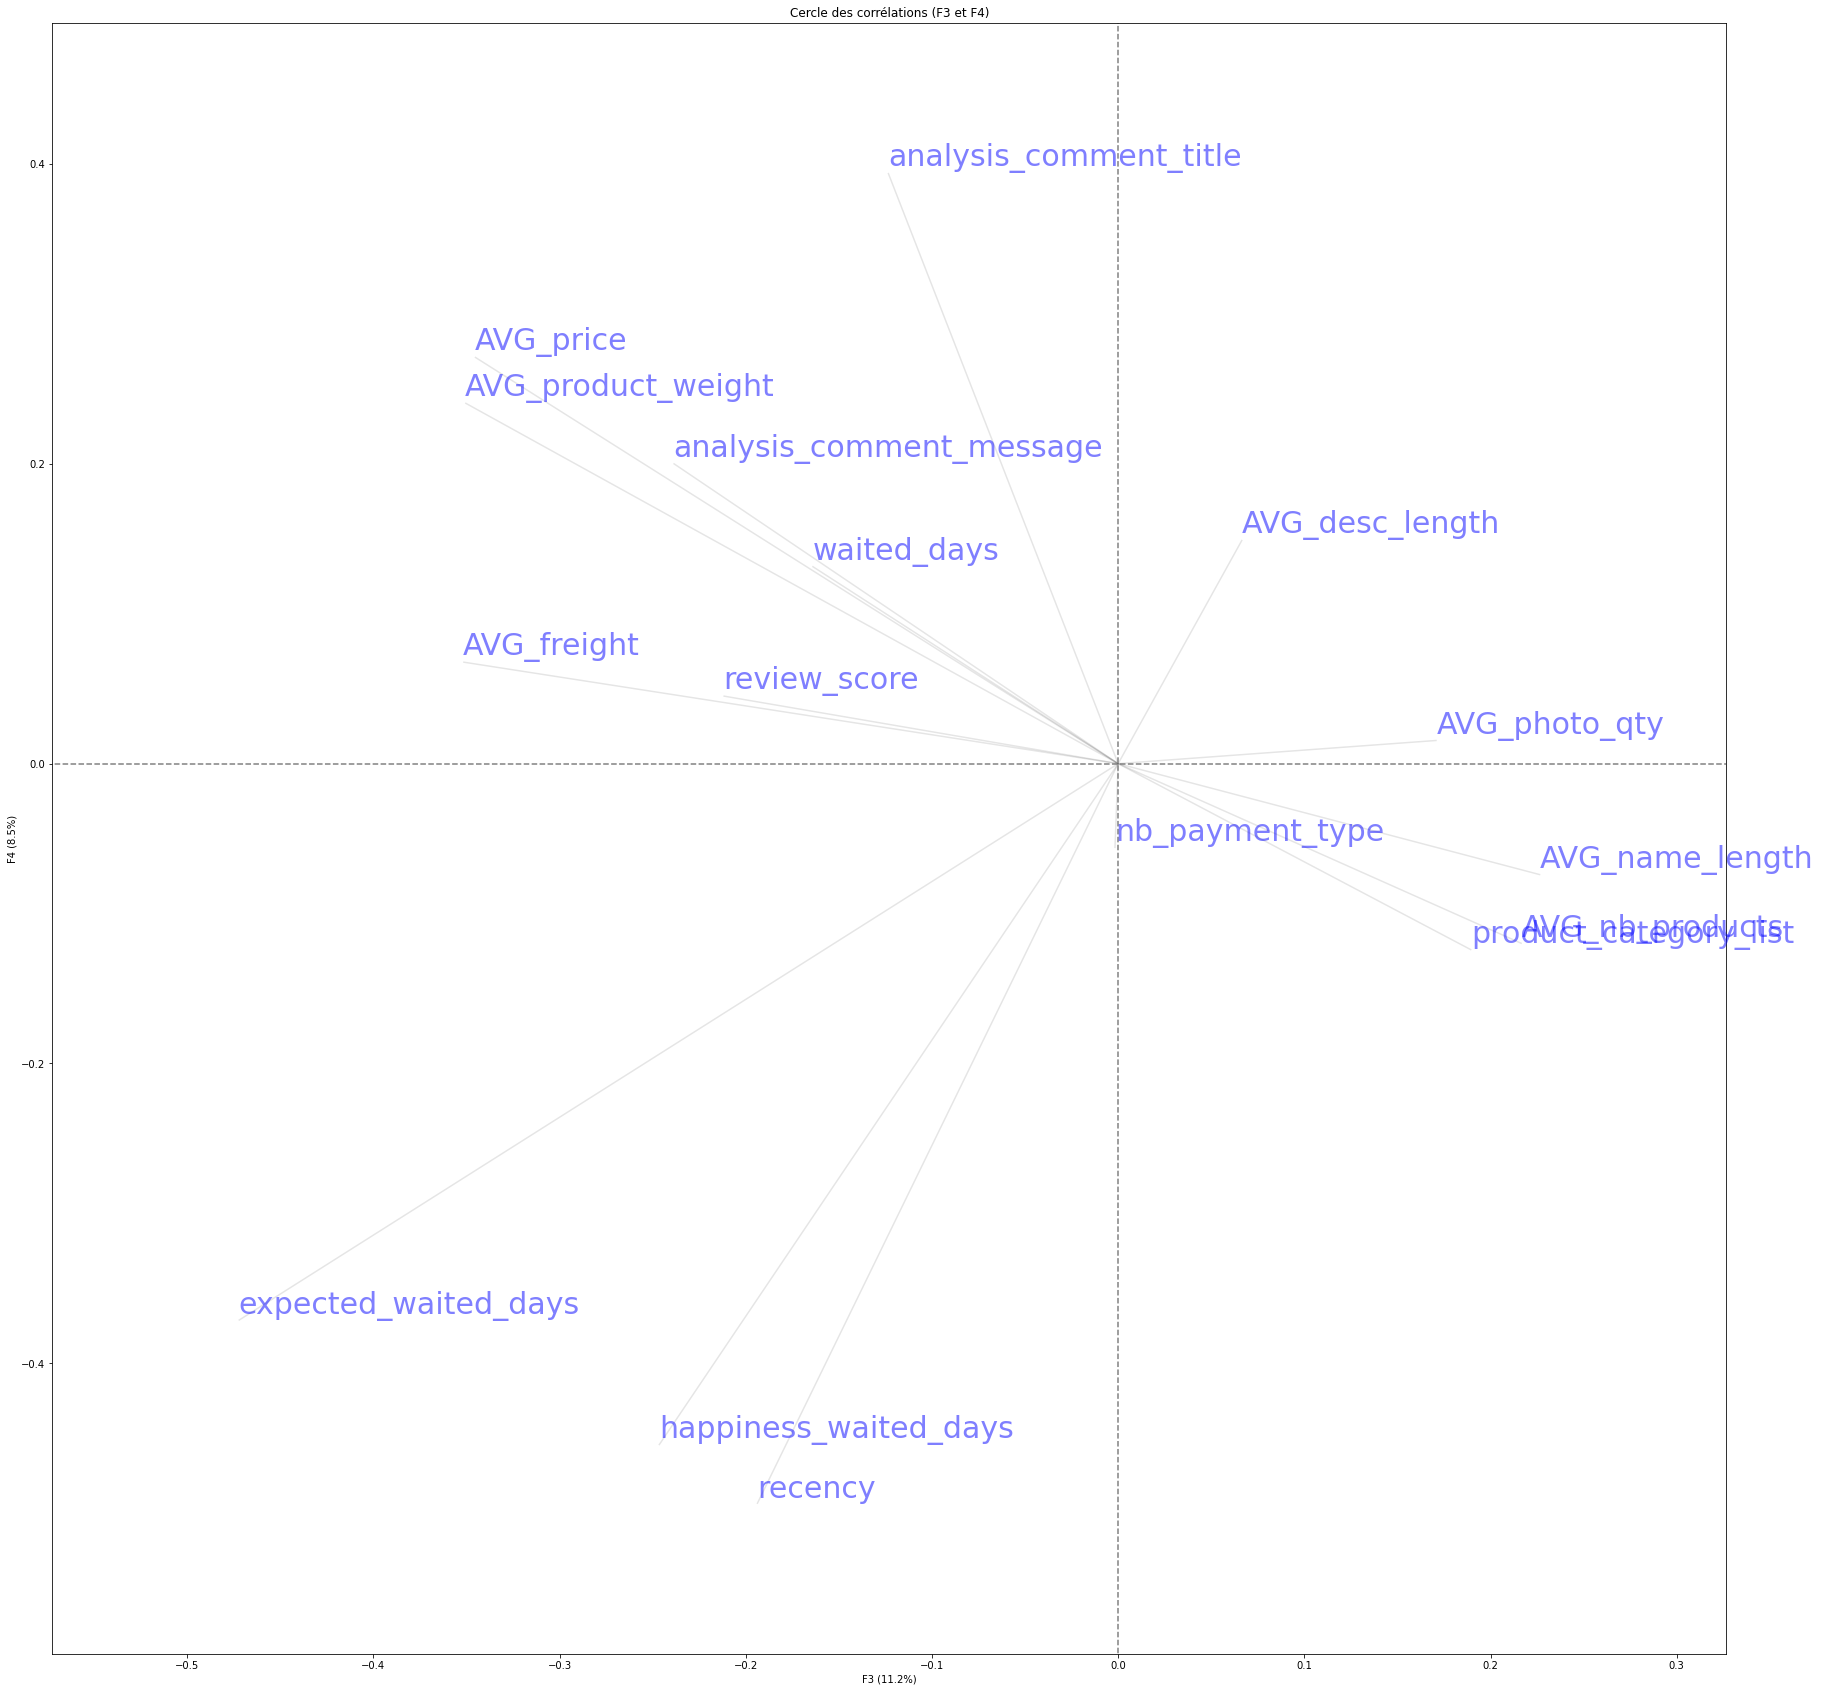

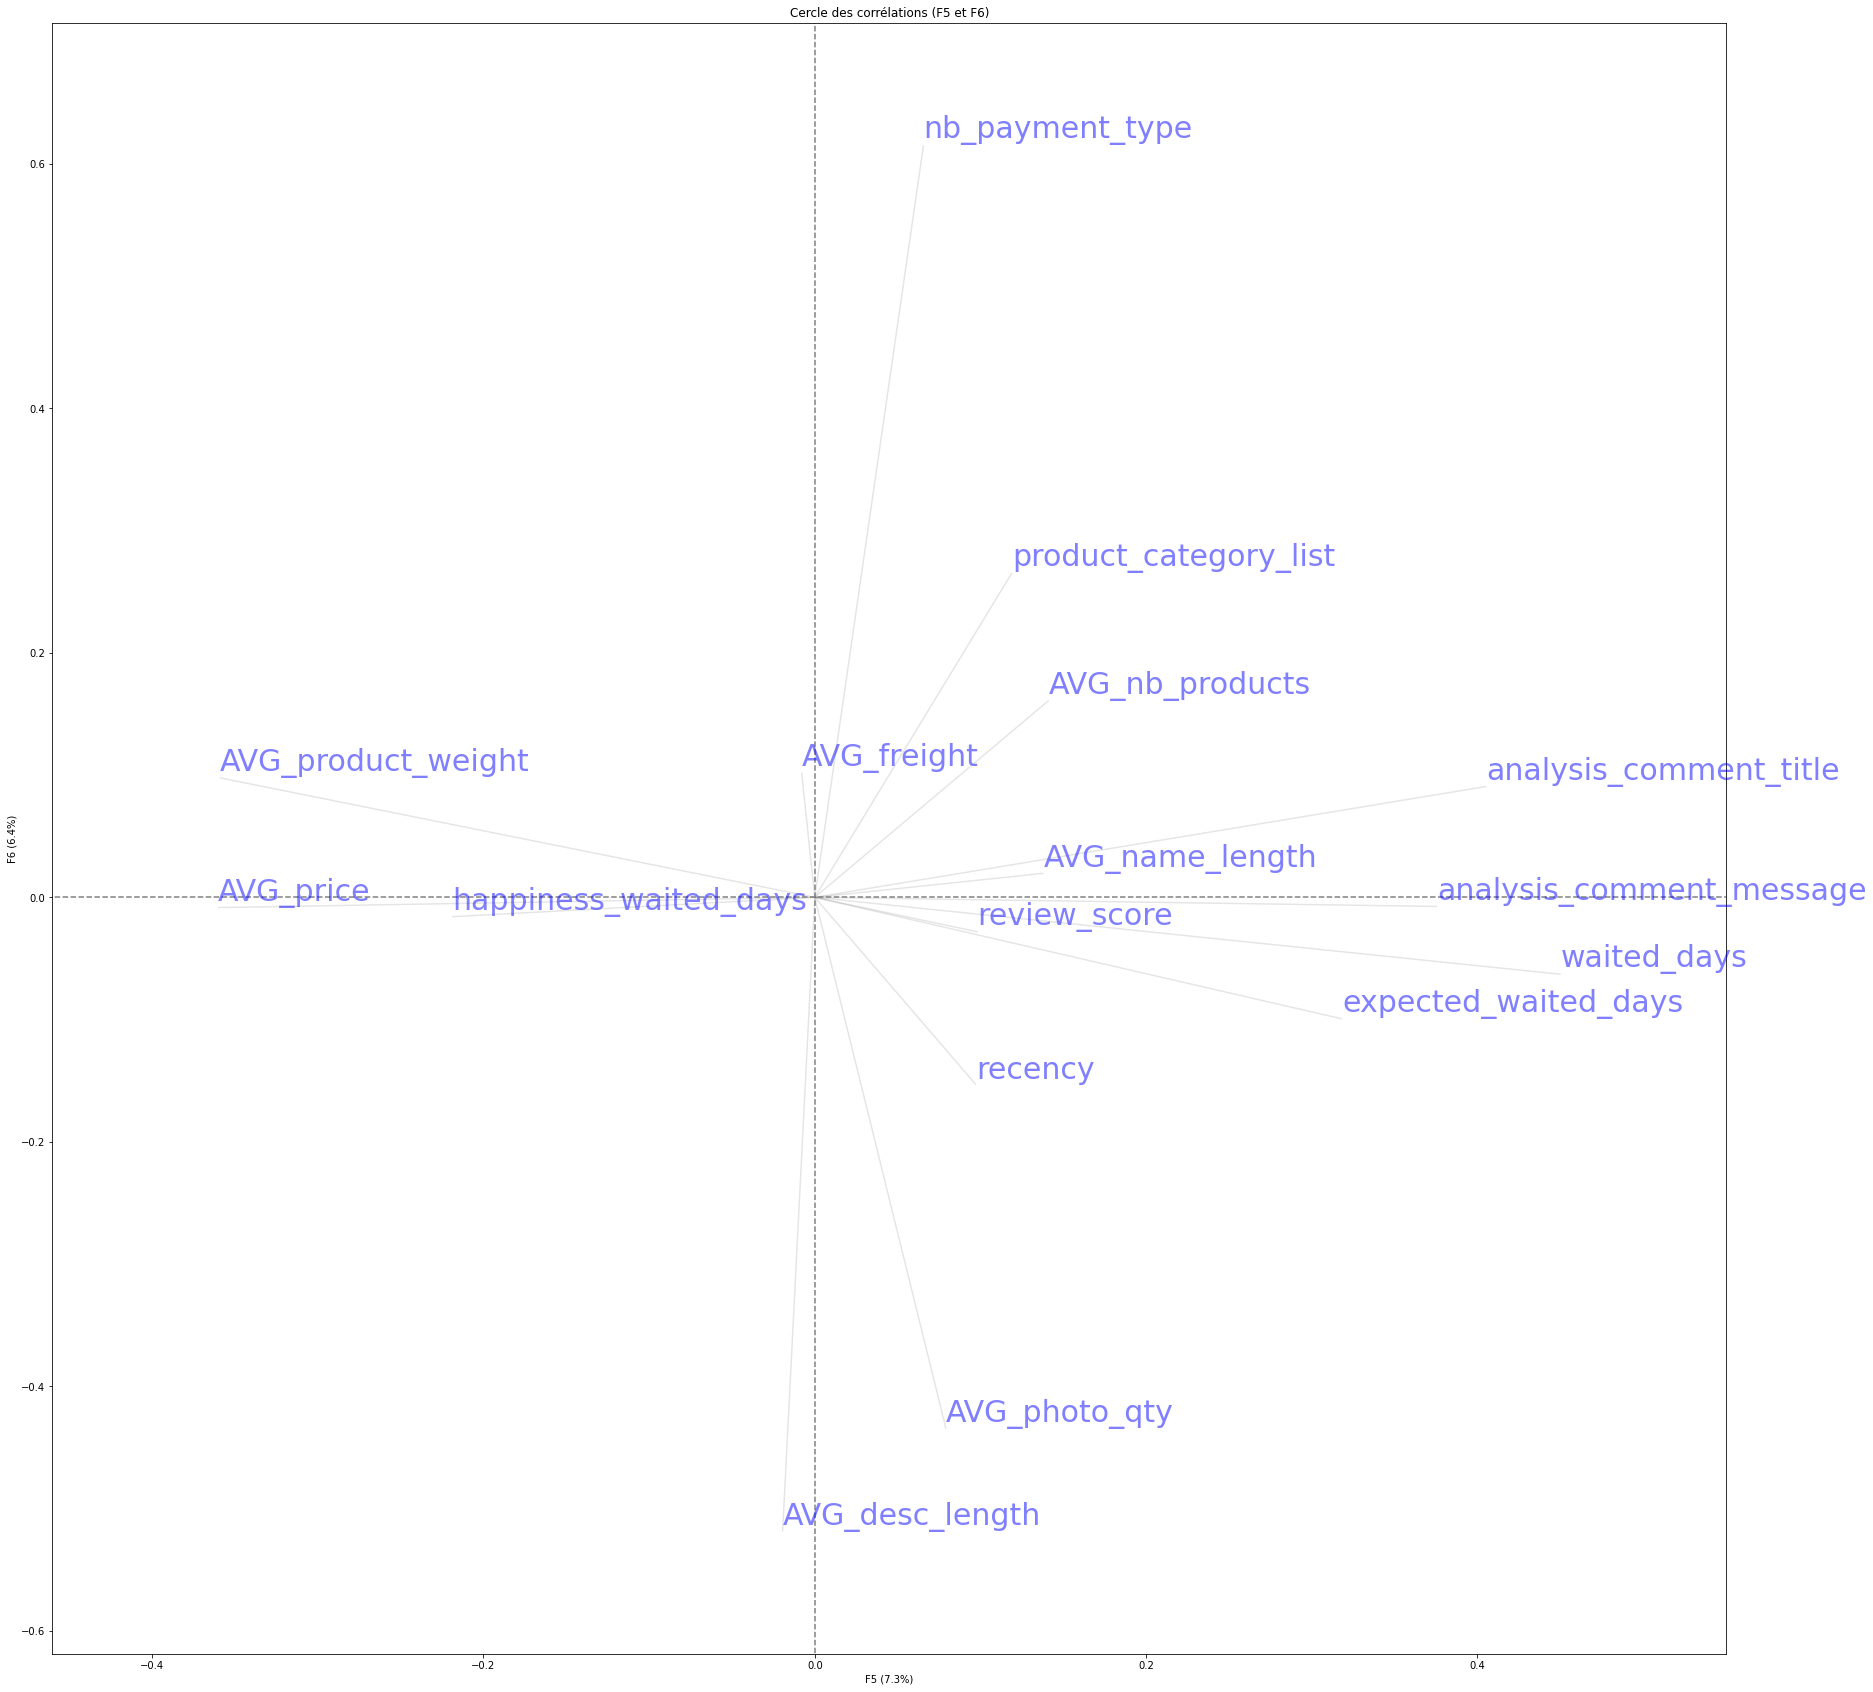

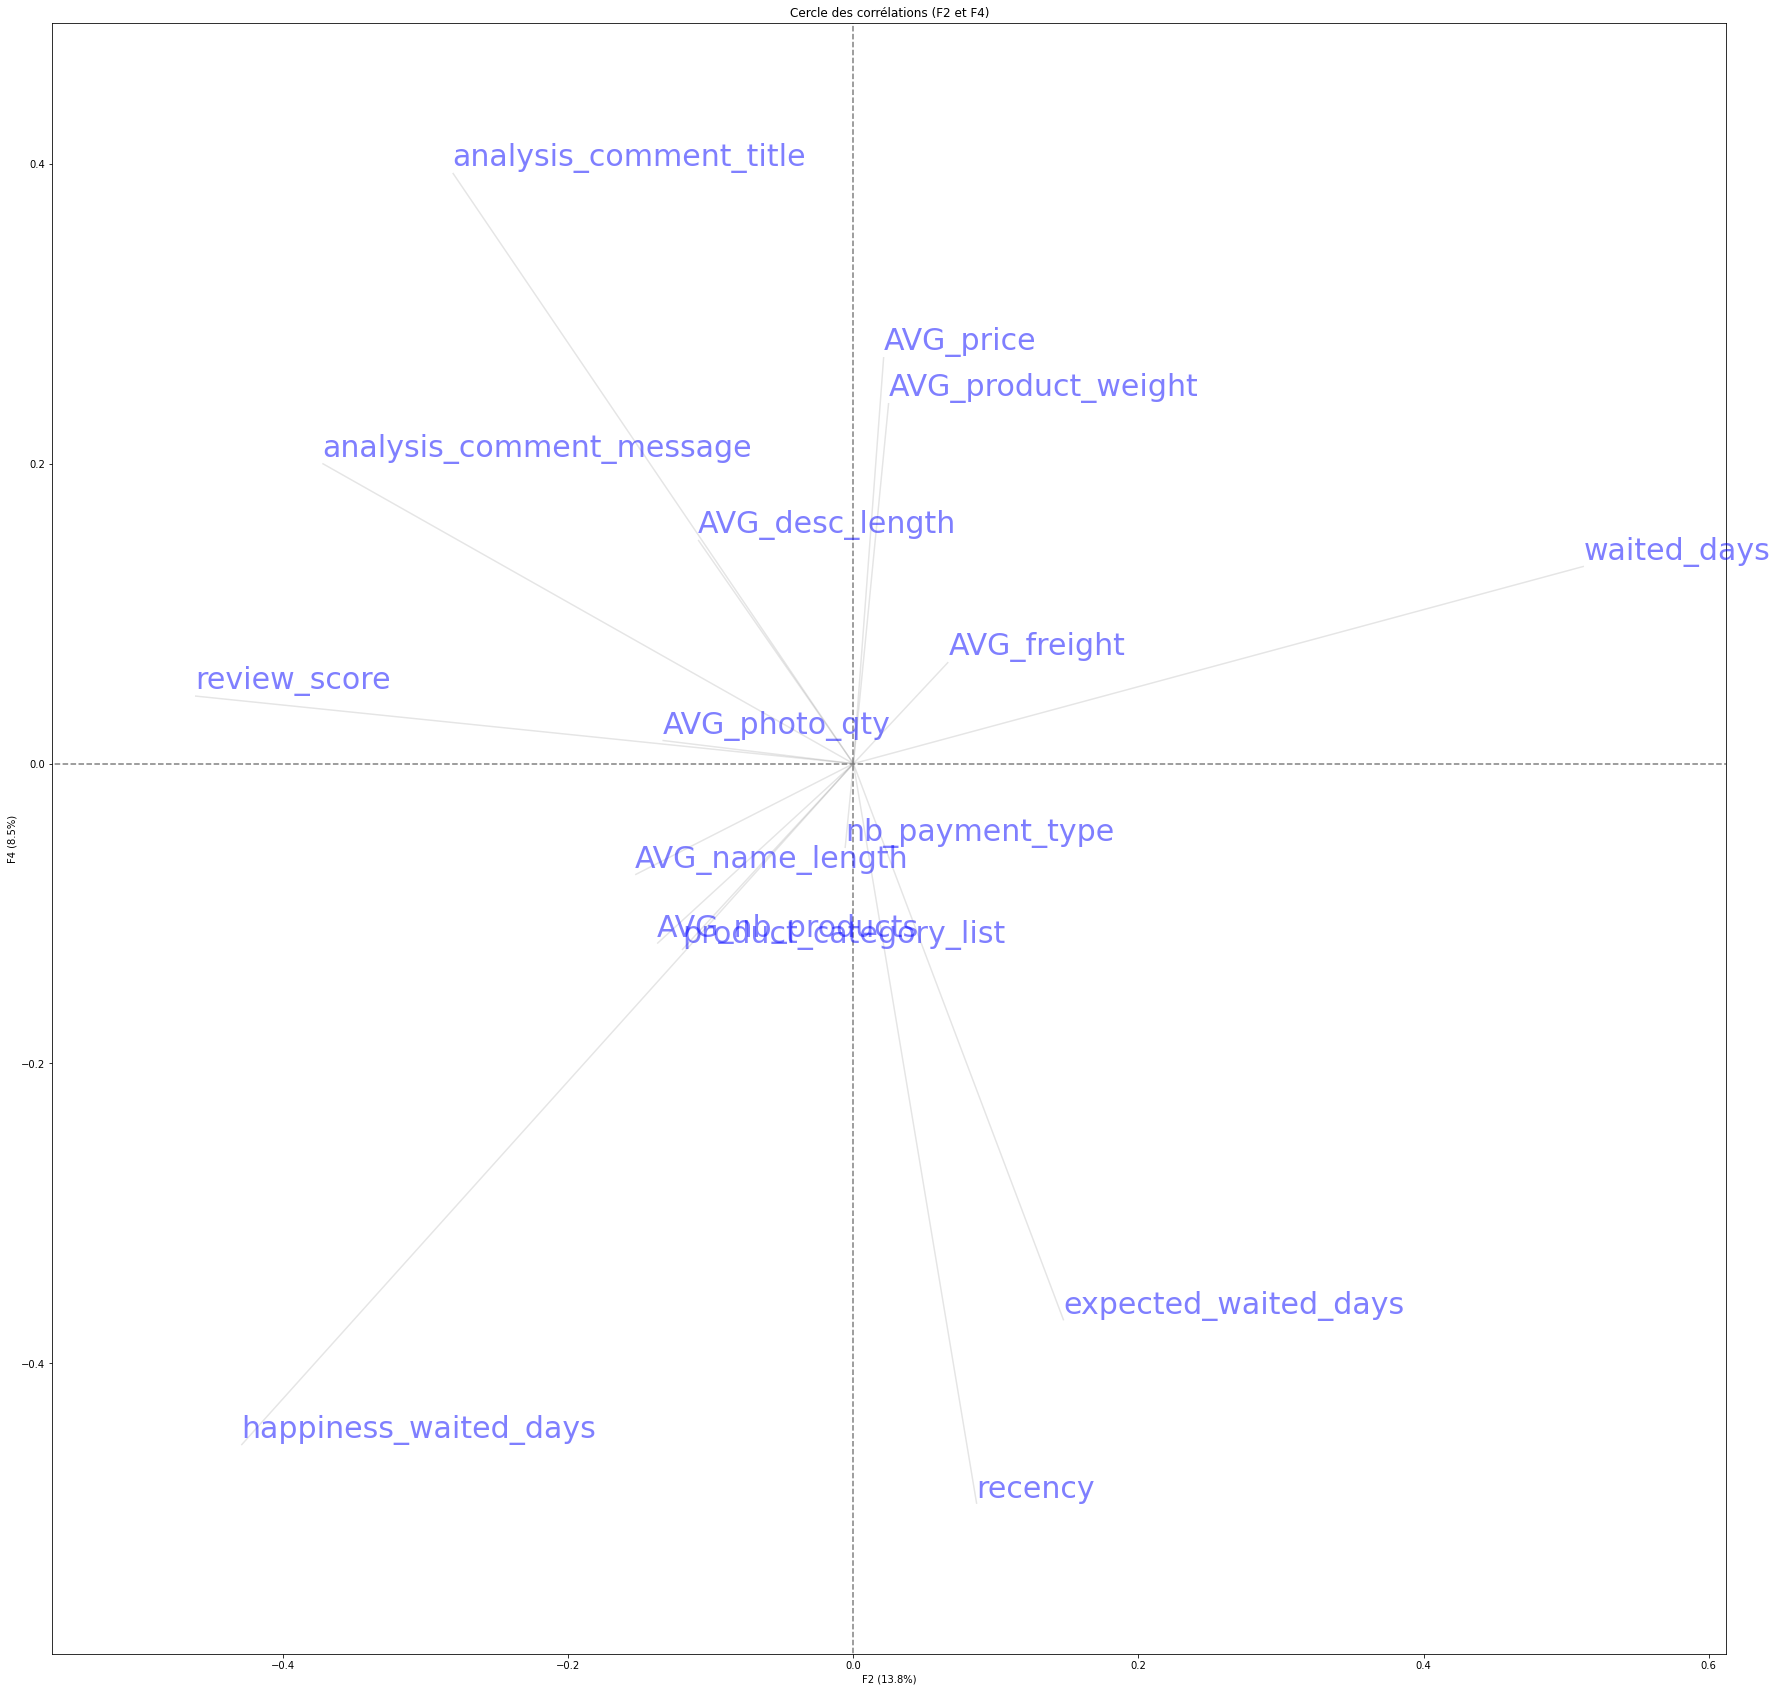

In [511]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5),(1,3)], labels = np.array(features))

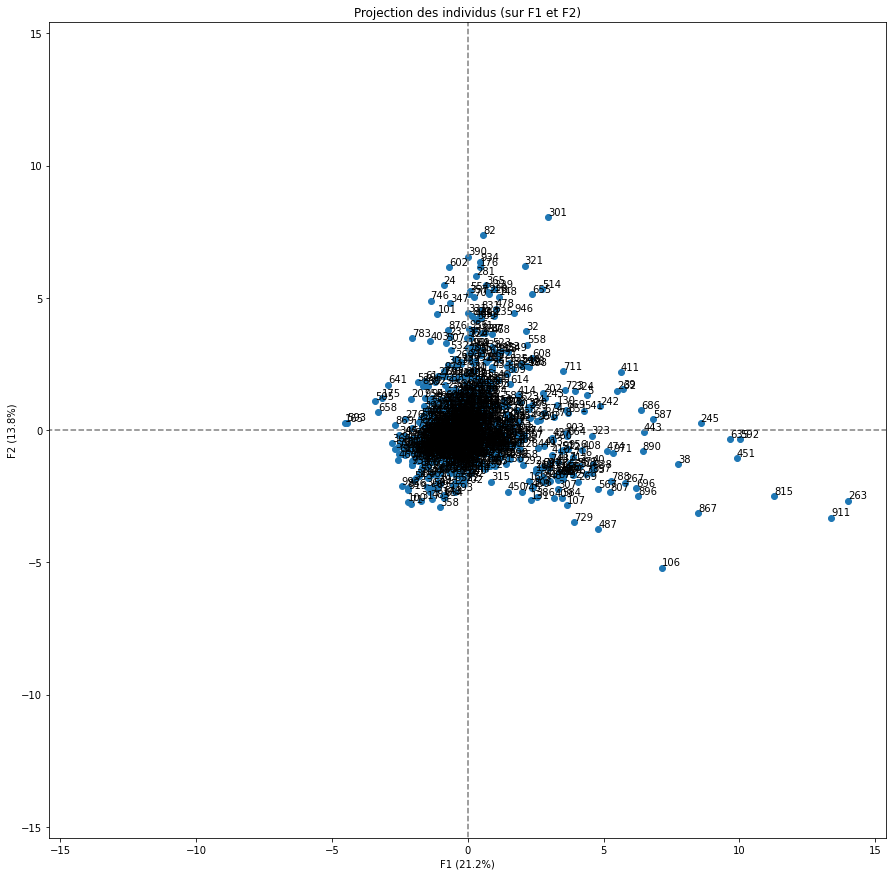

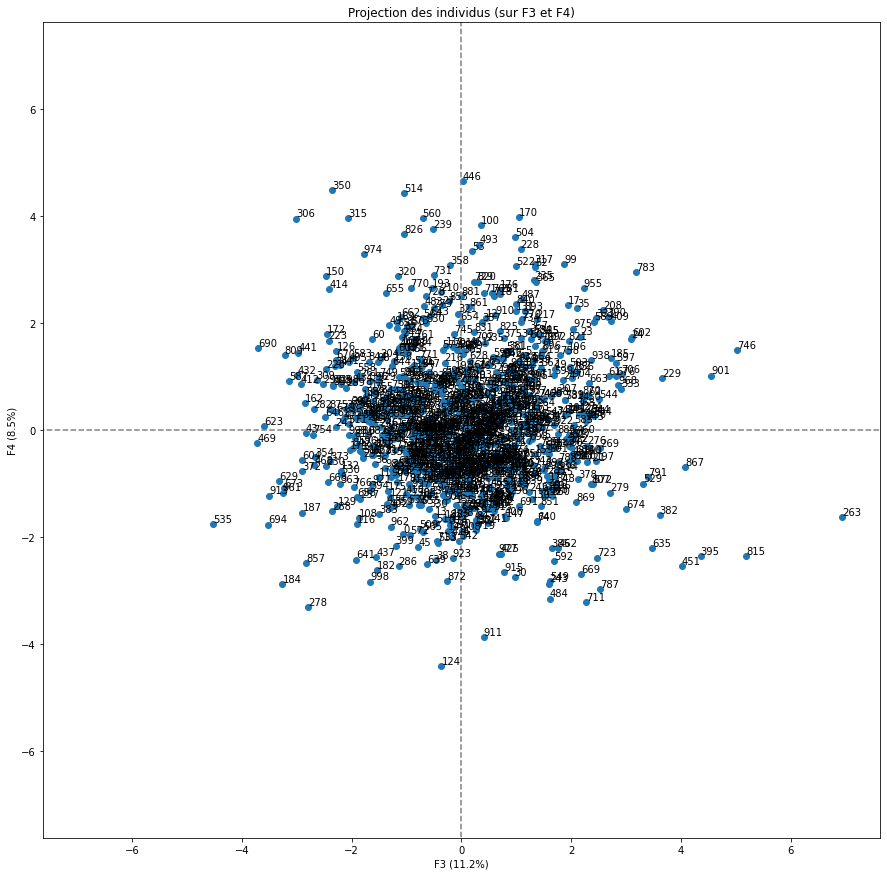

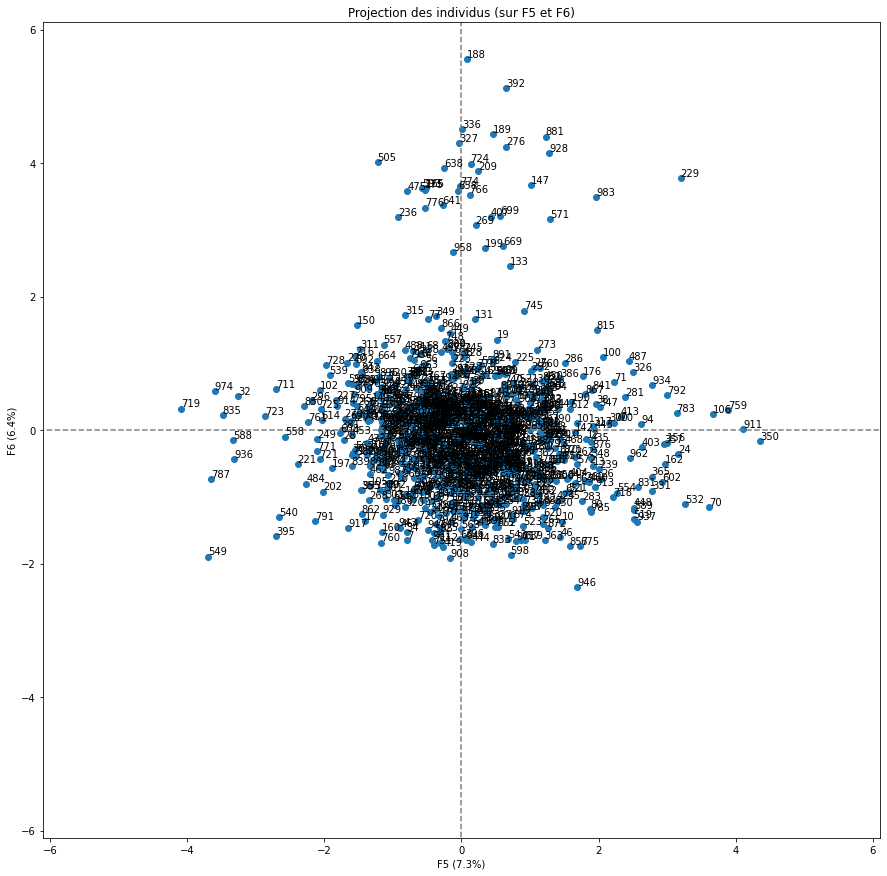

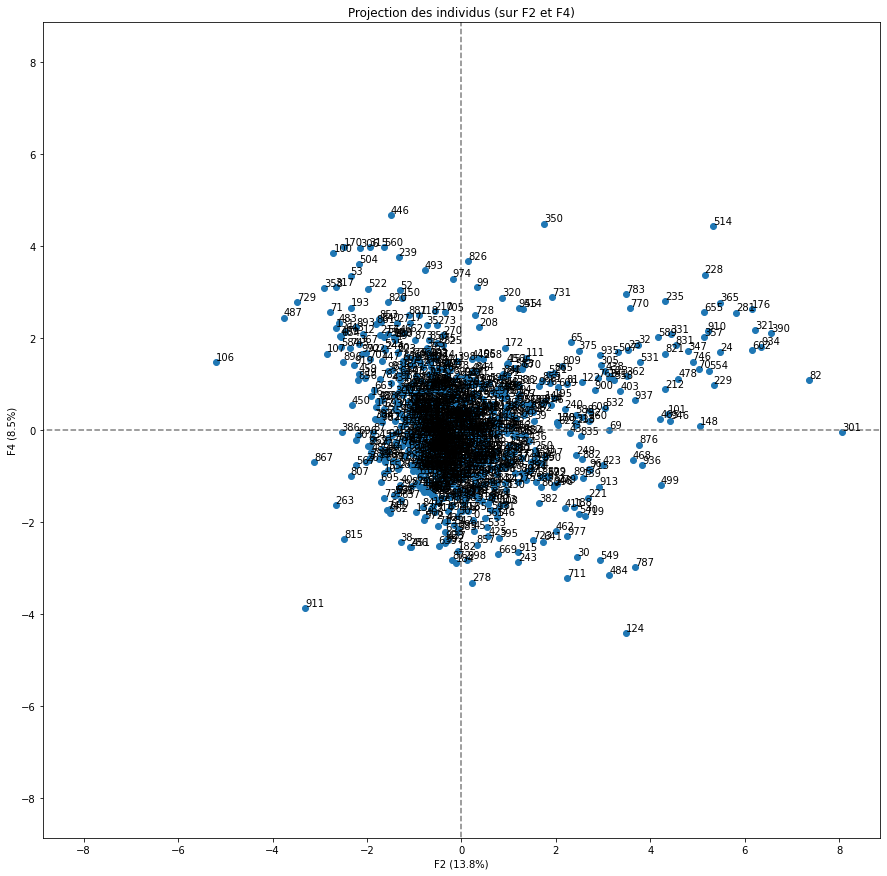

In [512]:
# Projection d'un échantillon d'individus
sample_index=random.sample(list(data.index),1000)
X_sample=X[sample_index]

X_projected = pca.transform(X_sample)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5),(1,3)], labels = np.array(names))

plt.show()

In [148]:
#retrouver l'individu 
#quelle variable fait diminuer les consommations

#3 niveaux
# feature importances
# partial dependences P(1|variable) max
# pour un individu donné, qu'est qui a joué pour obtenir la prédiction

#SHAP pour l'interpretabilité
#Simplement modifier le vecteur des valeurs prédites pour pas de valeurs négatives

In [149]:
model=modeling(linear_model.ElasticNet(max_iter=2000),X,label2015SEU,1)

0.294542852517053
explained variance :  0.32894500720113573
mean absolute error :  0.7293445054518872
median absolute error :  0.6418666230985792
mean squarred error :  0.8305231597728289
choice - mean squared log error :  0.003314702225362781


In [150]:
shap.initjs()

explainer = shap.LinearExplainer(model,data=X)

shapValues = explainer.shap_values(X)

shap.summary_plot(shapValues,X,feature_names=X.columns)

In [154]:
ind = 1142
shap.force_plot(
    explainer.expected_value, shapValues[ind,:],X.iloc[ind,:],
    feature_names=X.columns)

In [155]:
yPred=model.predict(X)

In [156]:
min(yPred)

13.885233530566268

In [157]:
np.where(yPred == min(yPred))

(array([1142], dtype=int64),)

In [158]:
X.iloc[1142,:]

NumberofBuildings                                                                                1.000000
PropertyGFATotal                                                                                 9.929009
PropertyGFAParking                                                                               0.000000
PropertyGFABuilding(s)                                                                           9.929009
LargestPropertyUseTypeGFA                                                                        9.313348
SecondLargestPropertyUseTypeGFA                                                                  8.987322
ThirdLargestPropertyUseTypeGFA                                                                   7.978077
ENERGYSTARScore                                                                                 99.000000
SteamUse(kBtu)                                                                                   0.000000
Electricity(kBtu)                             

#### Gradient boosting SEU RFE

In [176]:
selector = RFE(GradientBoostingRegressor(), n_features_to_select=100, step=50)

In [177]:
selector = selector.fit(X,label2015SEU)

In [179]:
#X.columns[selector.support_]

#### Gradient boosting SEU RFECV

In [915]:
#selector = RFECV(GradientBoostingRegressor(), min_features_to_select=10, step=50)

In [916]:
#selector = selector.fit(X,label2015SEU)

In [917]:
#X.columns[selector.support_]

In [186]:
model=GradientBoostingRegressor(ccp_alpha= 0.0001,
                                max_depth= 7,
                                min_samples_leaf= 1,
                                min_samples_split= 2,
                                n_estimators= 200,
                                warm_start= True)

In [188]:
featuresGradientBoosting=selectFeatures(model,X,label2015SEU,0)

In [189]:
print("Number of selected features : ",len(featuresGradientBoosting))
featuresGradientBoosting

Number of selected features :  58


Index(['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'nbUseTypes', 'ageBuilding',
       'x0_Multifamily HR (10+)', 'x0_Multifamily LR (1-4)',
       'x0_NonResidential', 'x0_Nonresidential COS', 'x0_SPS-District K-12',
       'x1_Distribution Center\n', 'x1_High-Rise Multifamily', 'x1_Hotel',
       'x1_Medical Office', 'x1_Mixed Use Property',
       'x1_Non-Refrigerated Warehouse', 'x1_Other',
       'x1_Refrigerated Warehouse', 'x1_Self-Storage Facility\n',
       'x1_Senior Care Community', 'x1_Small- and Mid-Sized Office',
       'x1_Supermarket/Grocery Store', 'x1_Worship Facility', 'x2_3', 'x2_5',
       'x2_7', 'x3_DOWNTOWN', 'x3_GREATER DUWAMISH', 'x4_Data Center',
       'x4_Distribution Center', 'x4_Hospital (General Medical & Surgical)',
       'x4_K-12 School', 'x4_Laboratory

In [190]:
modeling(model,X,label2015SEU,0,featuresGradientBoosting)

0.8067428793241129
explained variance :  0.8135727782750937
mean absolute error :  0.34046775976925864
median absolute error :  0.24591361377171417
mean squarred error :  0.22712986760461454
choice - mean squared log error :  0.0009469249982457793


GradientBoostingRegressor(ccp_alpha=0.0001, max_depth=7, n_estimators=200,
                          warm_start=True)

In [193]:
model=GradientBoostingRegressor(ccp_alpha= 0.0001,
                                max_depth= 7,
                                min_samples_leaf= 1,
                                min_samples_split= 2,
                                n_estimators= 200,
                                warm_start= True)

In [194]:
modeling(model,X,label2015SEU,1,featuresGradientBoosting)

0.8320385104434718
explained variance :  0.8569496823065075
mean absolute error :  0.2774315186733406
median absolute error :  0.17299857234161742
mean squarred error :  0.1710860118051546
choice - mean squared log error :  0.0007098297087337001


GradientBoostingRegressor(ccp_alpha=0.0001, max_depth=7, n_estimators=200,
                          warm_start=True)